## create groups of 65 slices using 3D Slicer

In [1]:
in_path = "C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/dicom_files/labels"
out_path = "C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/dicom_groups/labels"

In [2]:
from glob import glob
import shutil
import os

In [3]:
for patient in  glob(in_path + '/*' ):
    patient_name = os.path.basename(os.path.normpath(patient))
    number_folder = int(len(glob(patient+'/*'))/64)

    for i in range(number_folder):
        output_path_name = os.path.join(out_path, patient_name+"_"+ str(i))
        os.mkdir(output_path_name)

        for i, file in enumerate(glob(patient+'/*')):
            if i == 64 + 1:
                break
            shutil.move(file,output_path_name)

By changing the labels to images in in_path and out_path we can make the slices for patients

## Convert dicom files into nifties

In [4]:
import dicom2nifti

In [5]:
in_path_images = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/dicom_groups/images/*'
in_path_labels = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/dicom_groups/labels/*'

out_path_images = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/Nifti_files/images'
out_path_labels  = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/Nifti_files/labels'

list_images = glob(in_path_images)
list_labels = glob(in_path_labels)

In [6]:
for patient in list_images:
    patient_name = os.path.basename(os.path.normpath(patient))
    dicom2nifti.dicom_series_to_nifti(patient, os.path.join(out_path_images, patient_name + ".nii.gz"))

In [7]:
for patient in list_labels:
    patient_name = os.path.basename(os.path.normpath(patient))
    dicom2nifti.dicom_series_to_nifti(patient, os.path.join(out_path_labels, patient_name + ".nii.gz"))

Find empty

In [8]:
import nibabel as nib
import numpy as np


input_nifti_file_path = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/Nifti_files/labels/liver_0_0.nii.gz'
list_input_nifti = glob(input_nifti_file_path)

for patient in list_input_nifti:

    nifti_file = nib.load(patient)
    fdata = nifti_file.get_fdata()

    np_unique = np.unique(fdata)
    if len(np_unique) == 1:
        print(patient)



### Preprocessing Using Monai

In [9]:
import os
from glob import glob
#import shutil
#from tqdm import tqdm
#import dicom2nifti
#import numpy as np
#import nibabel as nib
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)


In [10]:
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.utils import first
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstD, Spacingd, Orientationd, ScaleIntensityRanged,
    CropForegroundd, Resized, ToTensord
)

In [11]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [12]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


c:\Users\Dinesh\anaconda3\envs\mlenv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset:   0%|          | 0/103 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 26/26 [08:37<00:00, 19.90s/it]


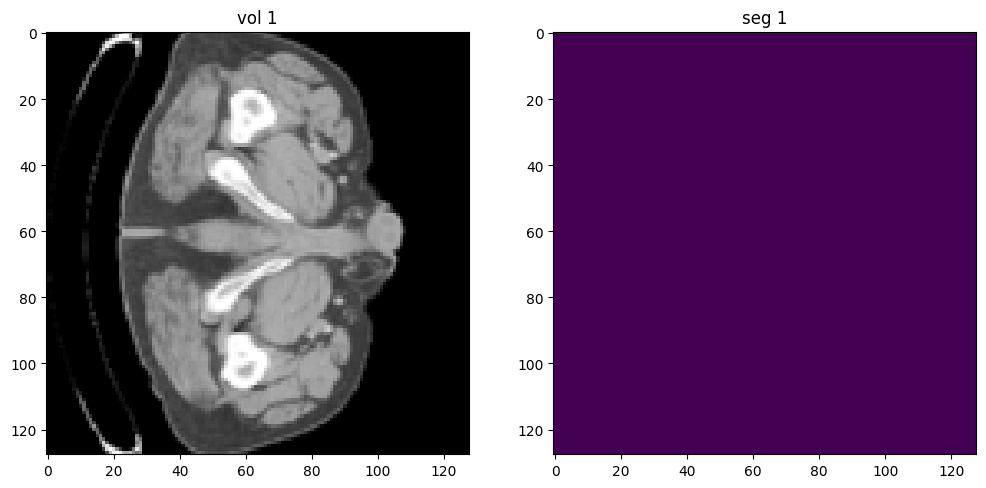

In [13]:
in_dir = "C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/Data_train_test"

patient = prepare(in_dir)
show_patient(patient)

In [14]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cpu")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")



In [15]:
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [16]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch

data_dir = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/Data_train_test'
model_dir = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/results/results' 
#data_in = prepare(data_dir, cache=True)
# as loading takes time, we have already loaded the images as patients using funtion prepare we can use that



In [17]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, patient, loss_function, optimizer,20, model_dir)

----------
epoch 1/20
1/103, Train_loss: 0.5499
Train_dice: 0.4501
2/103, Train_loss: 0.5308
Train_dice: 0.4692
3/103, Train_loss: 0.5255
Train_dice: 0.4745
4/103, Train_loss: 0.5415
Train_dice: 0.4585
5/103, Train_loss: 0.5567
Train_dice: 0.4433
6/103, Train_loss: 0.5550
Train_dice: 0.4450
7/103, Train_loss: 0.5441
Train_dice: 0.4559
8/103, Train_loss: 0.5325
Train_dice: 0.4675
9/103, Train_loss: 0.5611
Train_dice: 0.4389
10/103, Train_loss: 0.5506
Train_dice: 0.4494
11/103, Train_loss: 0.5460
Train_dice: 0.4540
12/103, Train_loss: 0.5454
Train_dice: 0.4546
13/103, Train_loss: 0.5512
Train_dice: 0.4488
14/103, Train_loss: 0.5649
Train_dice: 0.4351
15/103, Train_loss: 0.5391
Train_dice: 0.4609
16/103, Train_loss: 0.5449
Train_dice: 0.4551
17/103, Train_loss: 0.5410
Train_dice: 0.4590
18/103, Train_loss: 0.5367
Train_dice: 0.4633
19/103, Train_loss: 0.5704
Train_dice: 0.4296
20/103, Train_loss: 0.5402
Train_dice: 0.4598
21/103, Train_loss: 0.5380
Train_dice: 0.4620
22/103, Train_loss: 0

TESTING

In [18]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [19]:
in_dir = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/Data_train_test'
model_dir = 'C:/Users/Dinesh/Desktop/Liver_segmentation/Task03_Liver/results/results' 

In [20]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

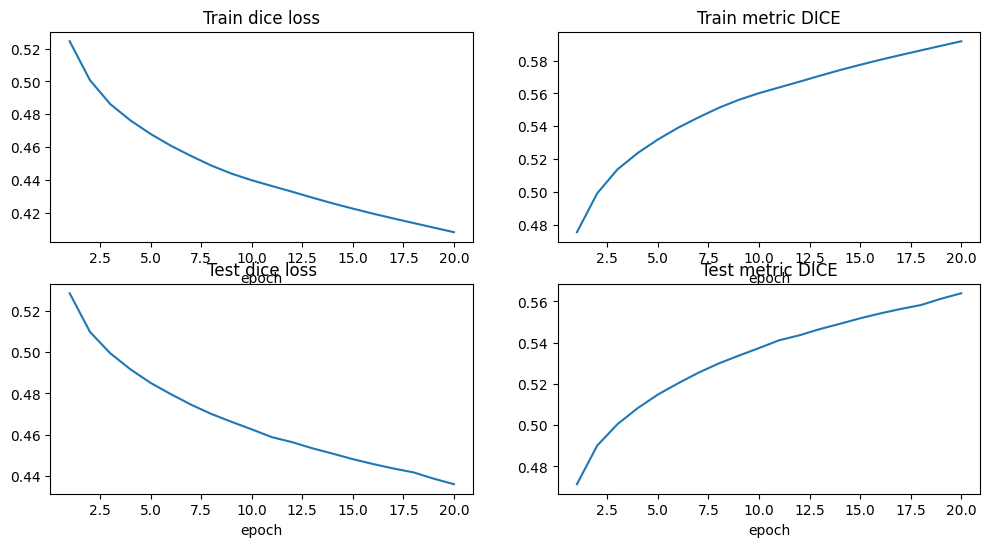

In [21]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [43]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]


In [44]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstD(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

c:\Users\Dinesh\anaconda3\envs\mlenv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [45]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [47]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [48]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


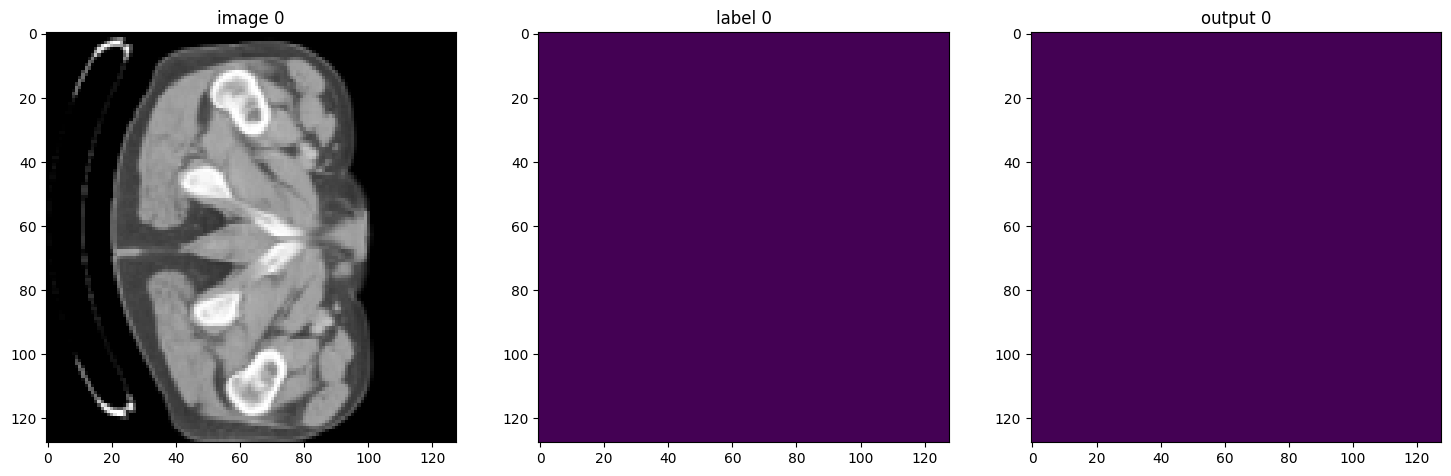

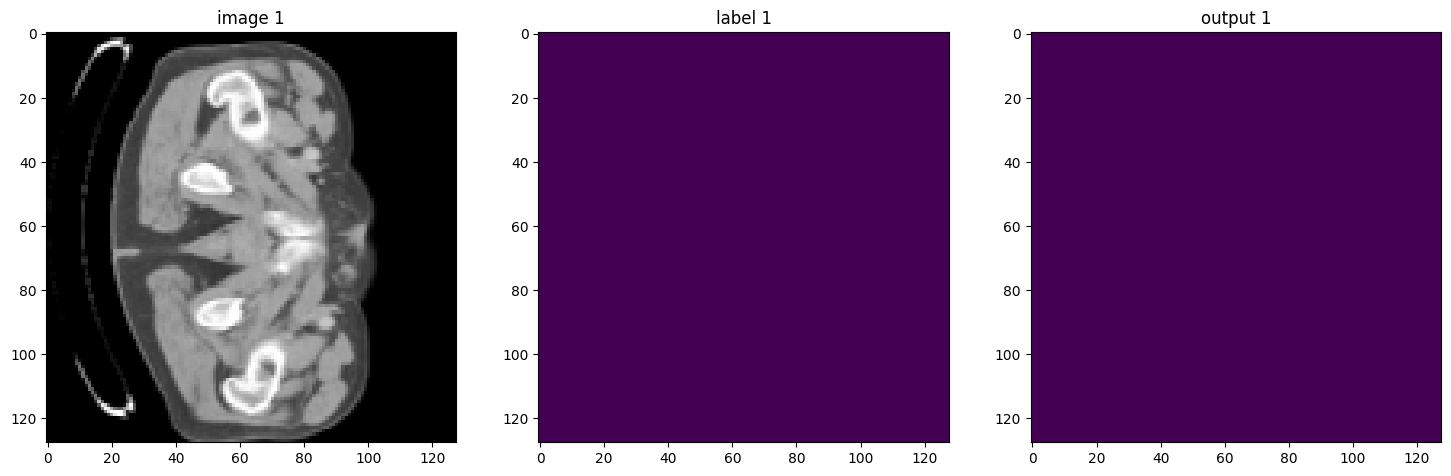

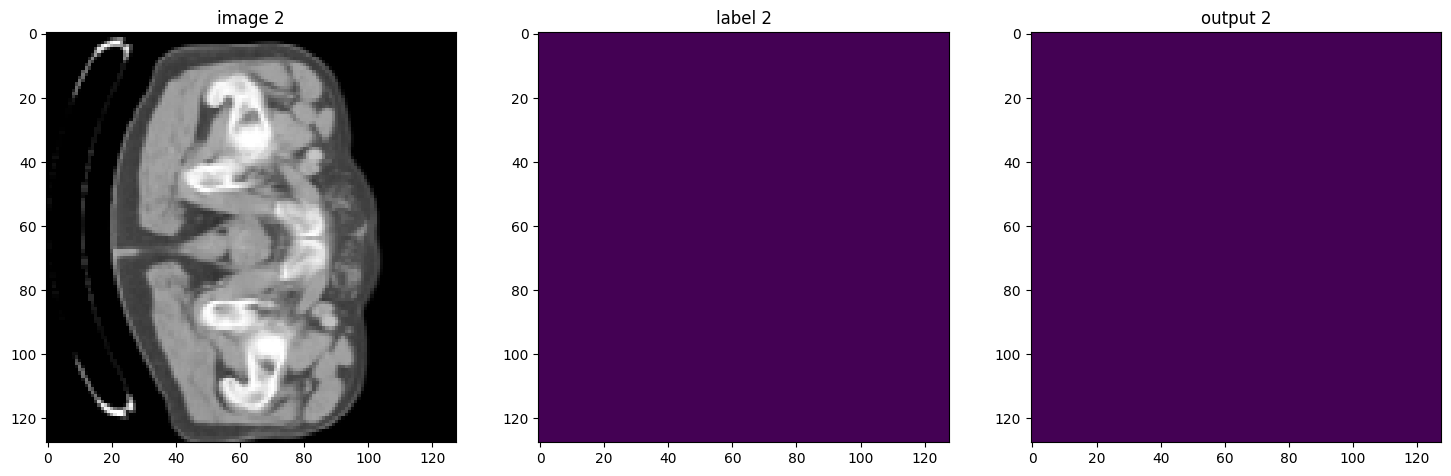

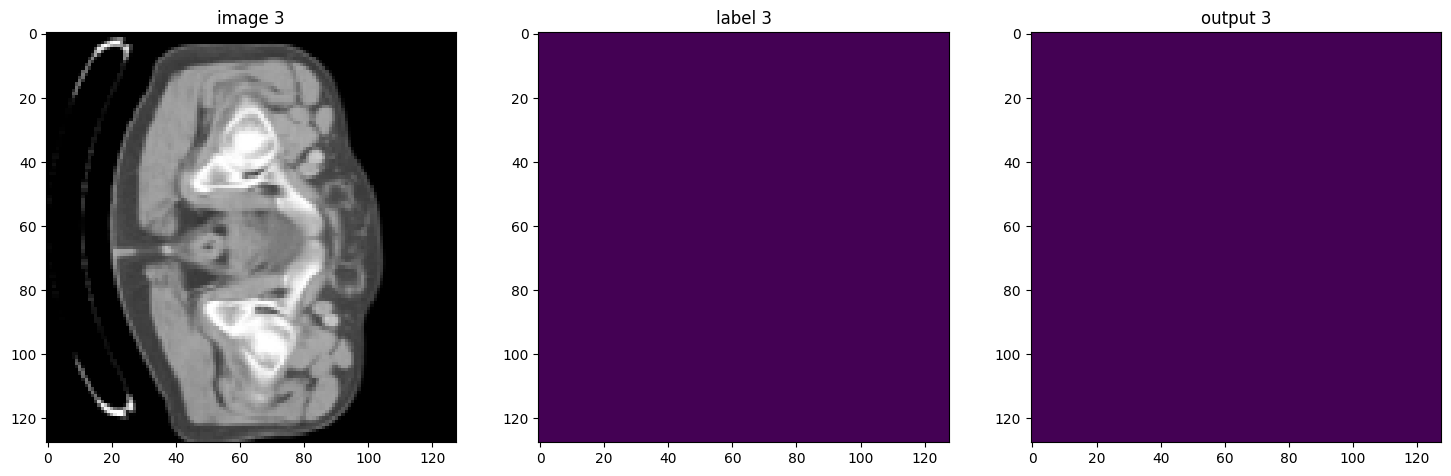

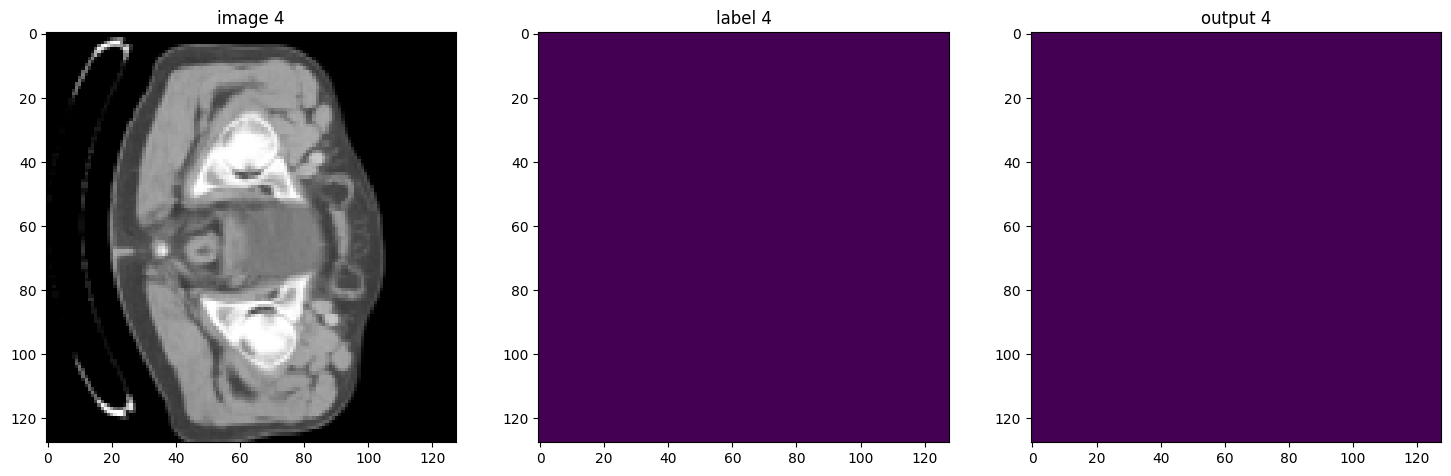

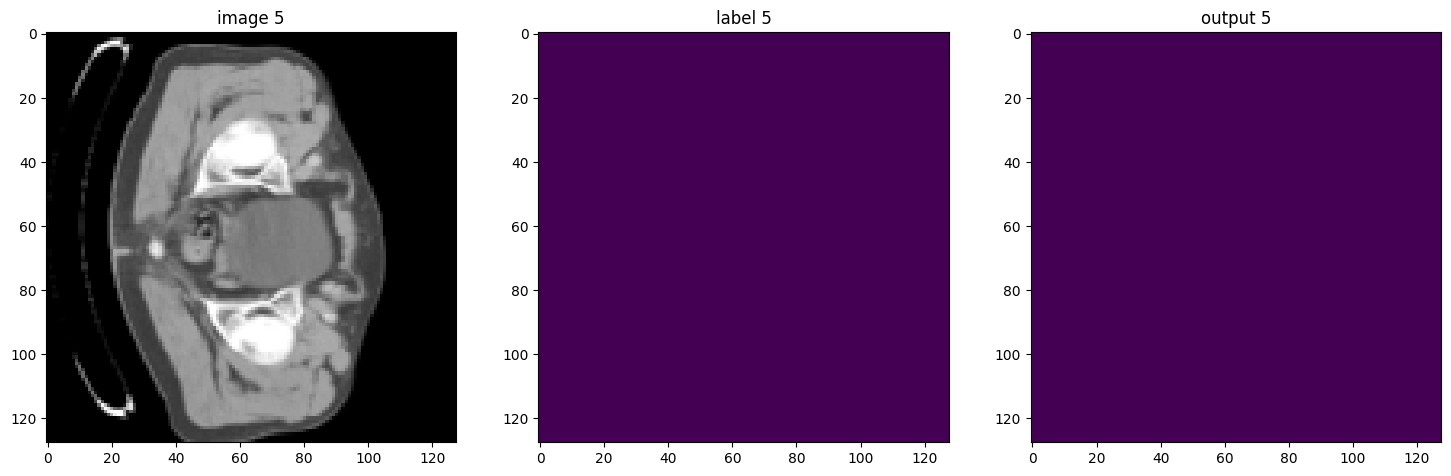

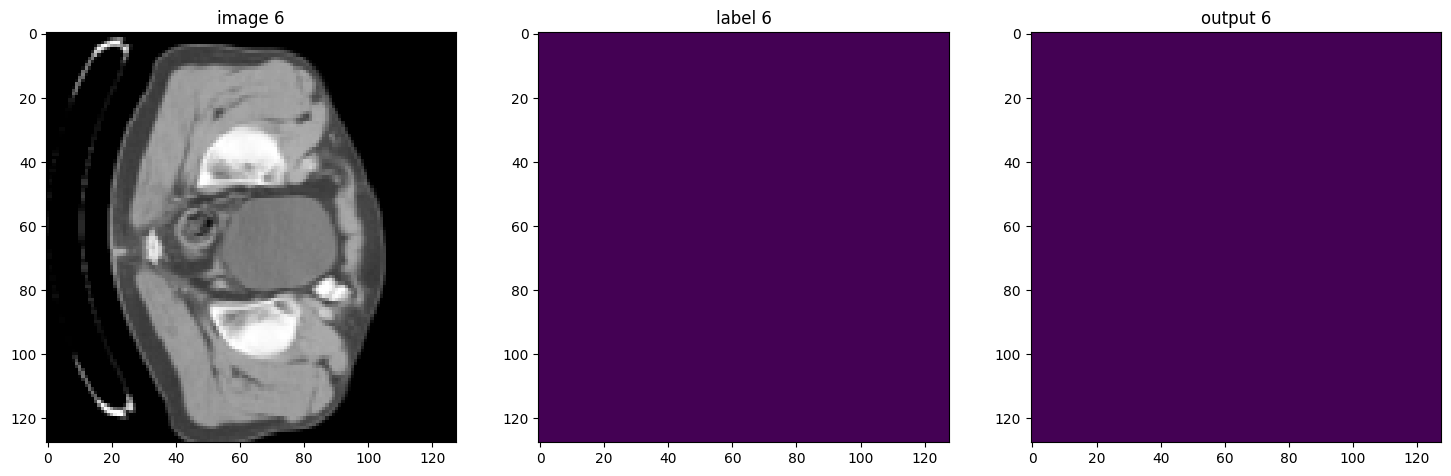

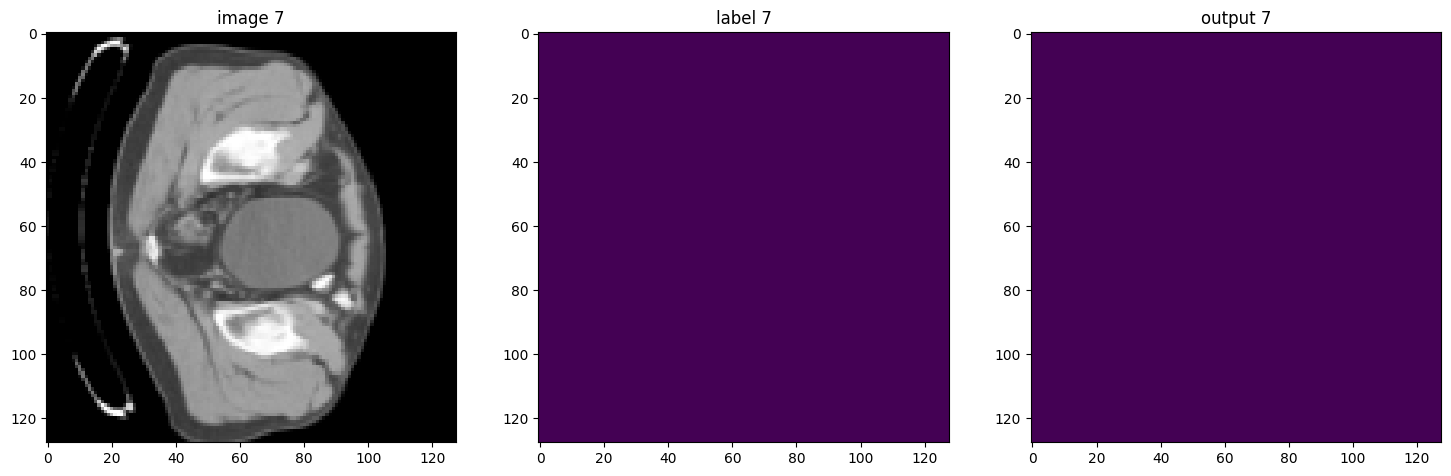

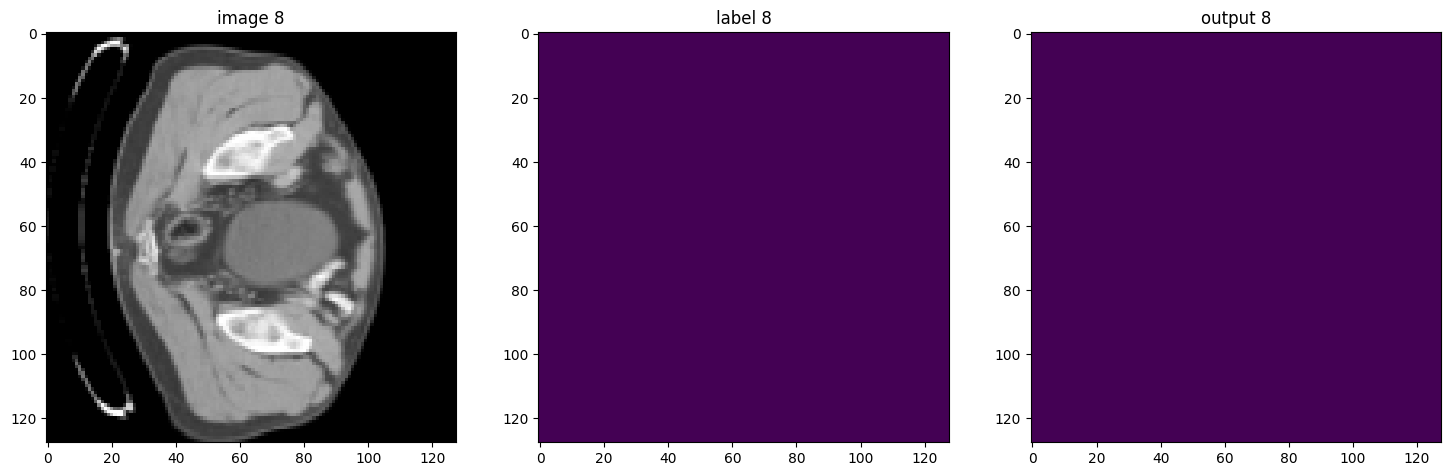

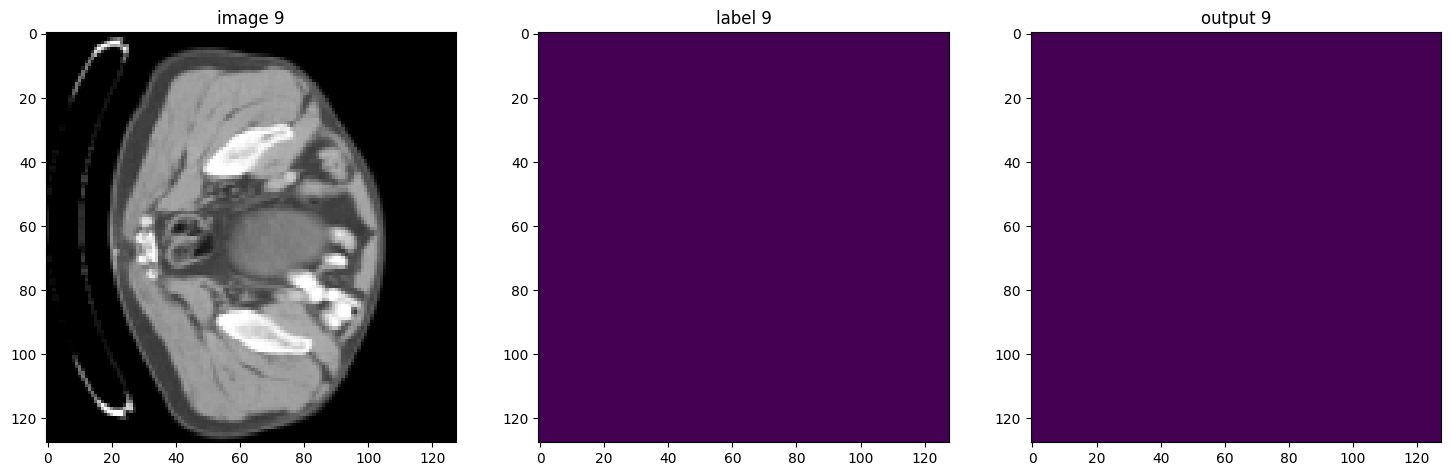

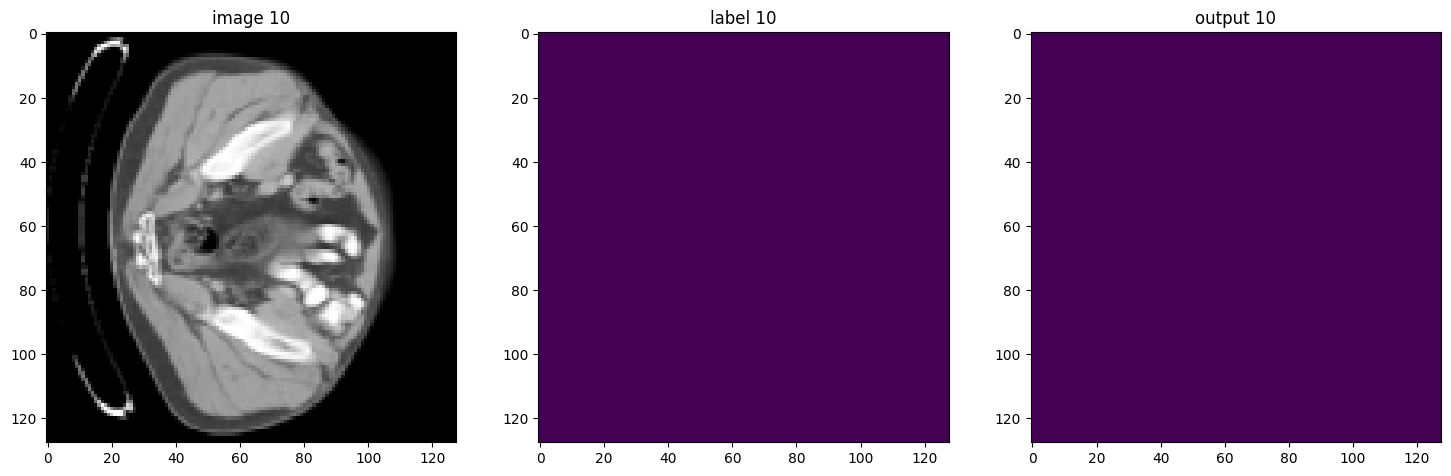

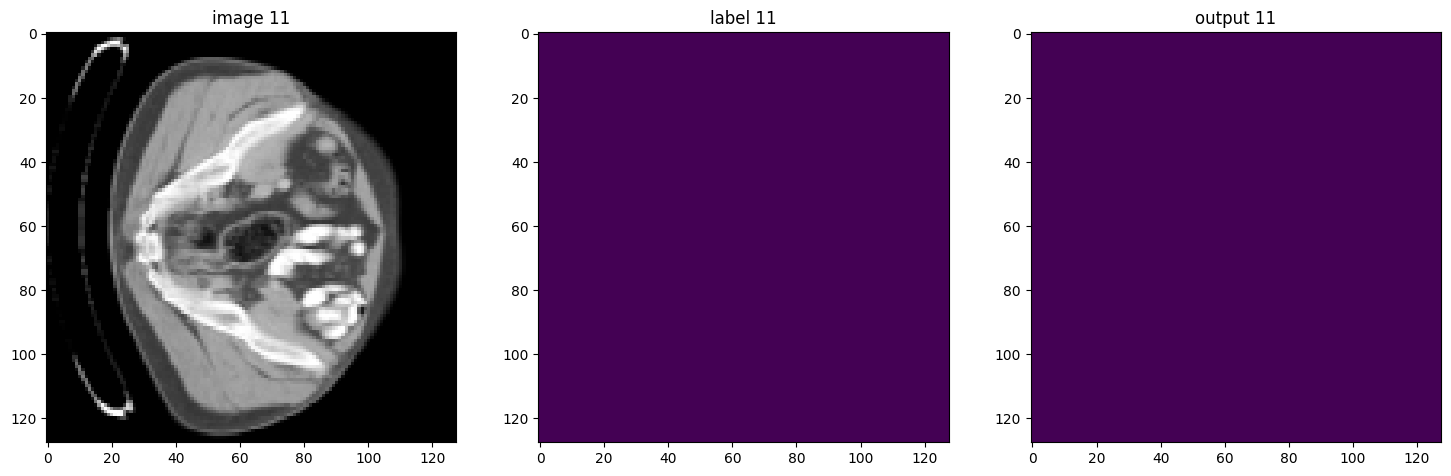

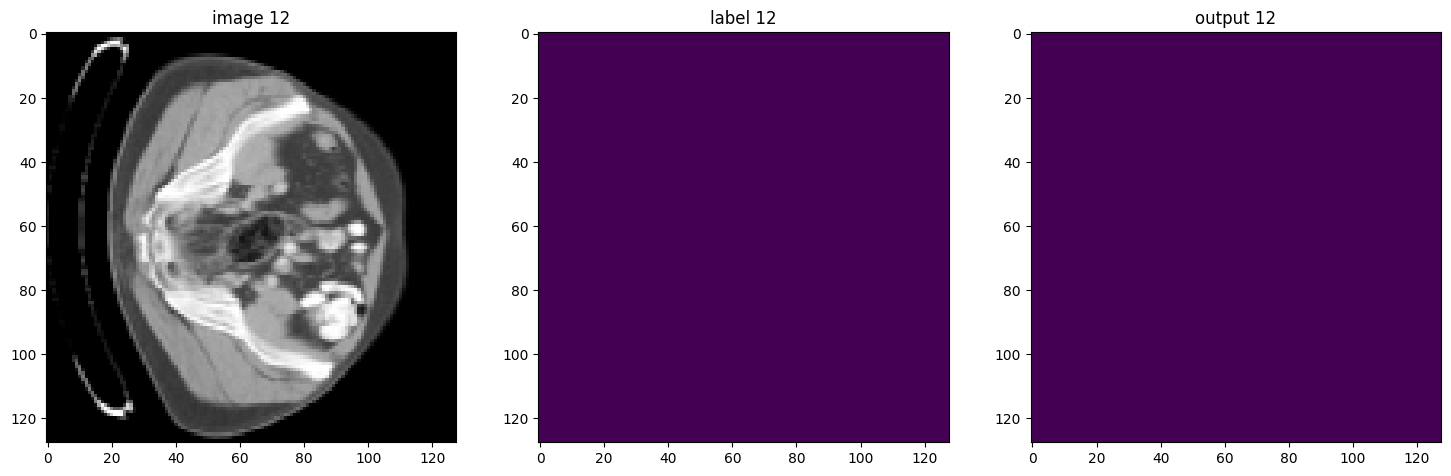

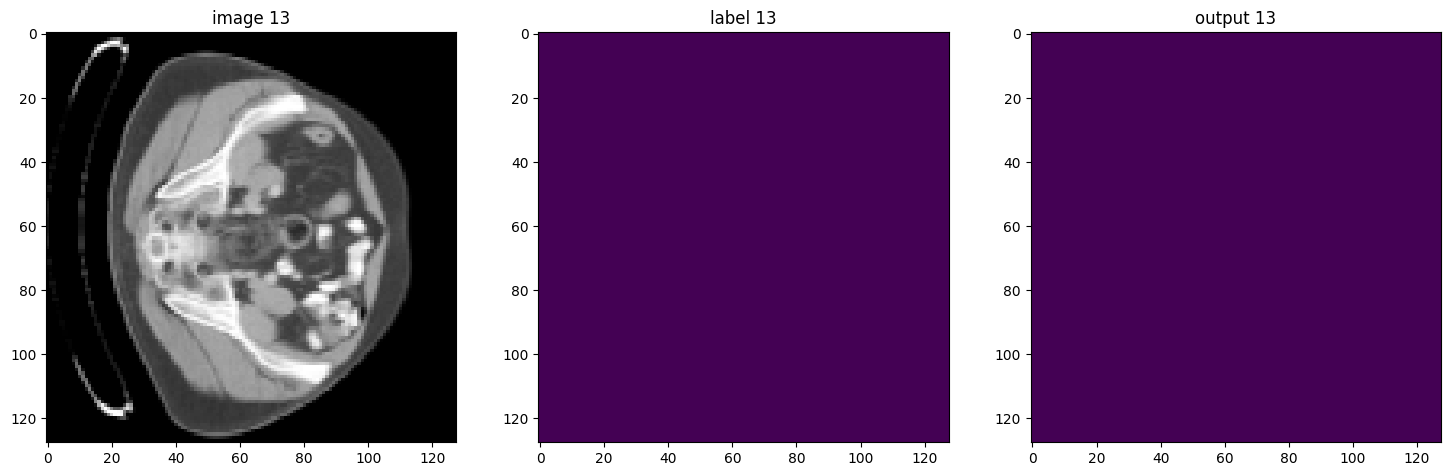

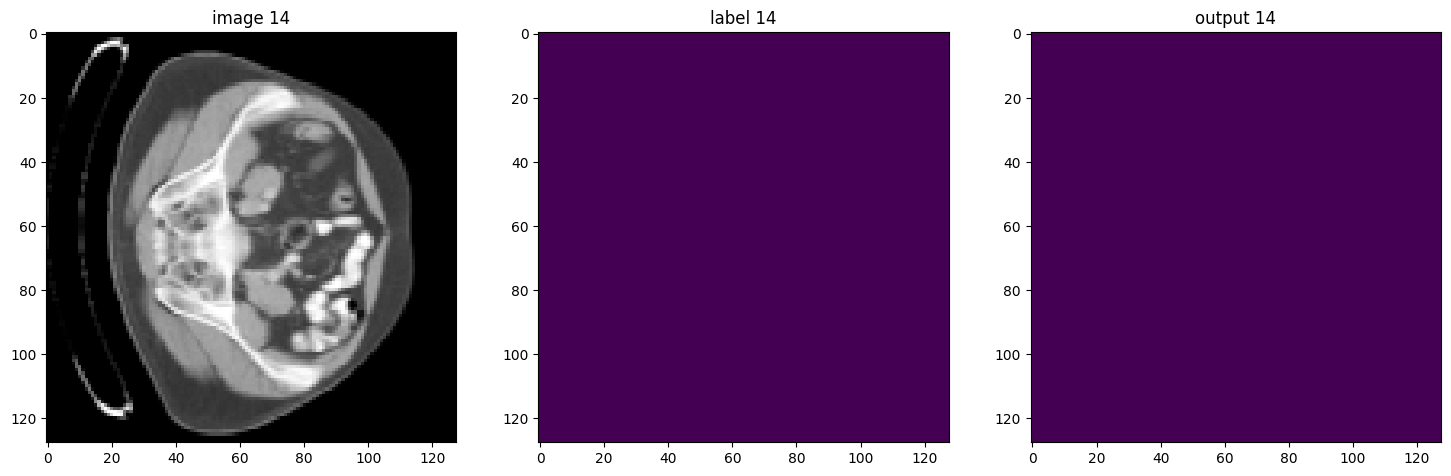

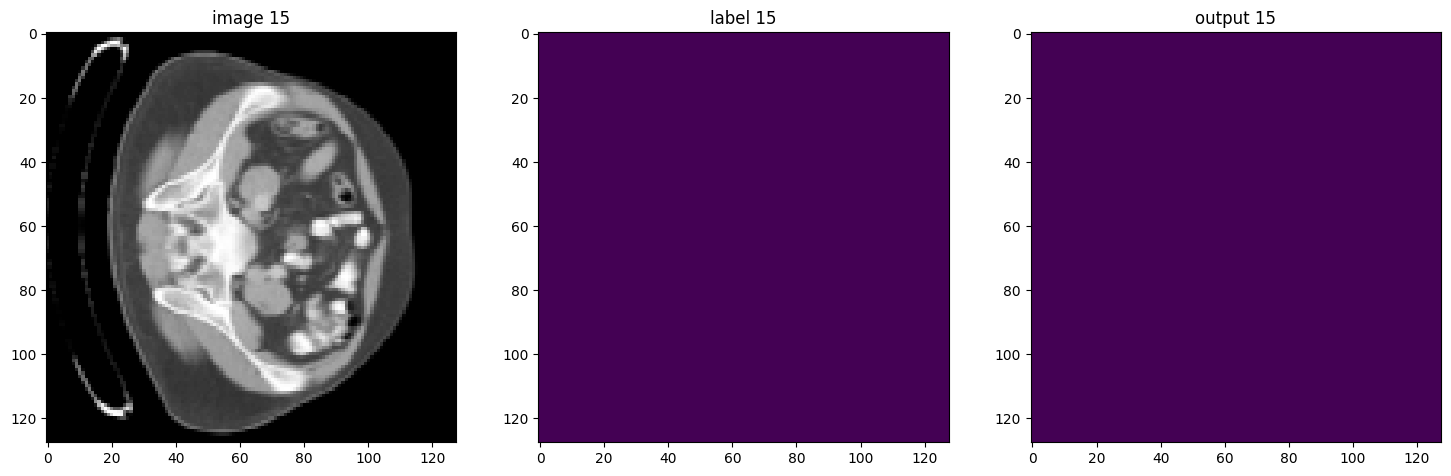

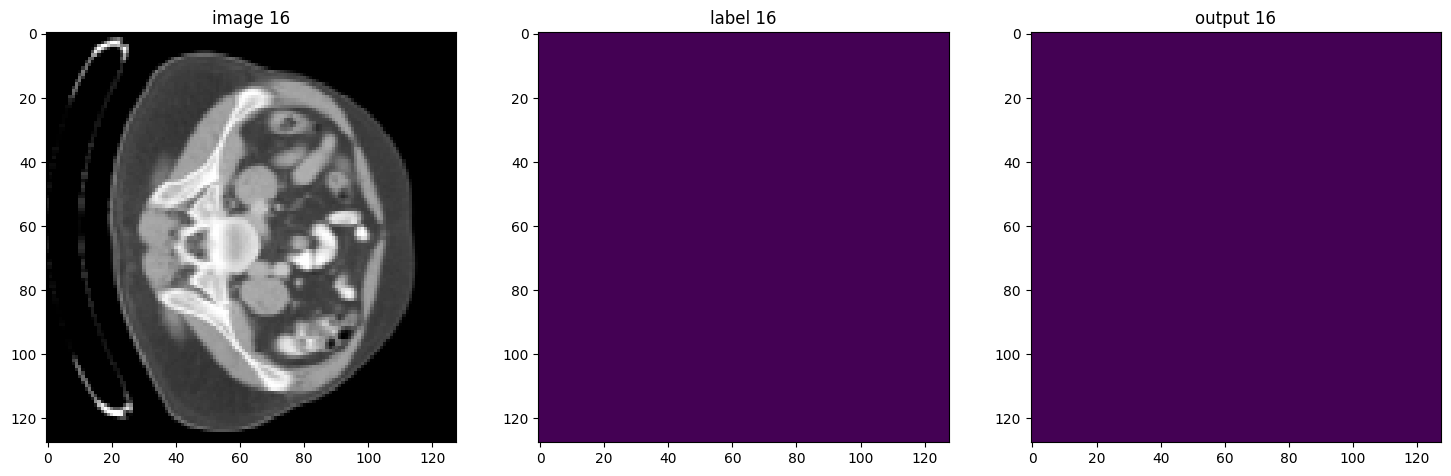

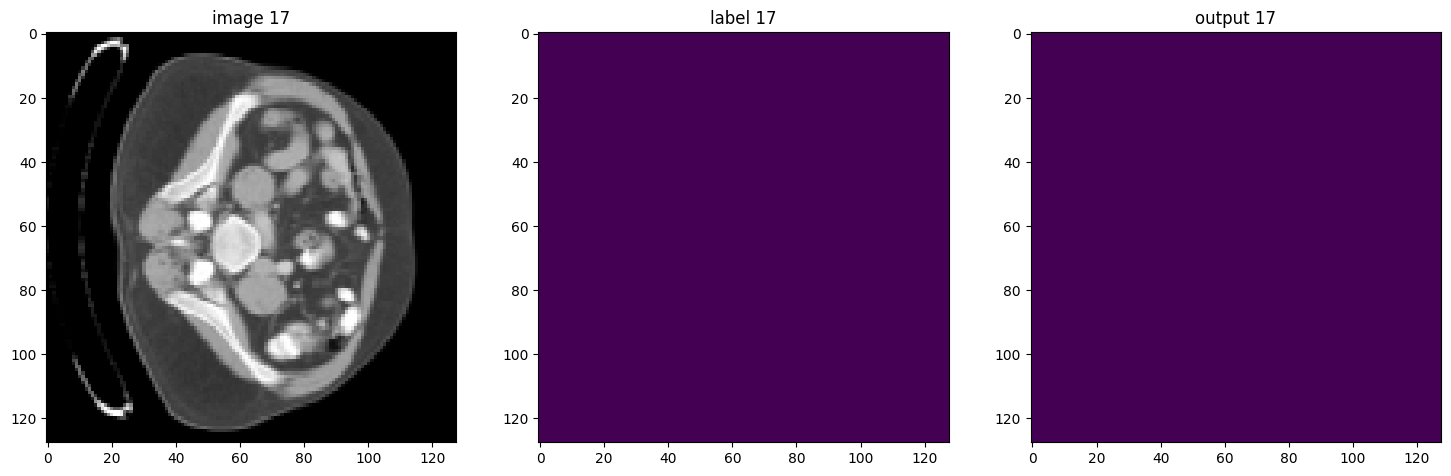

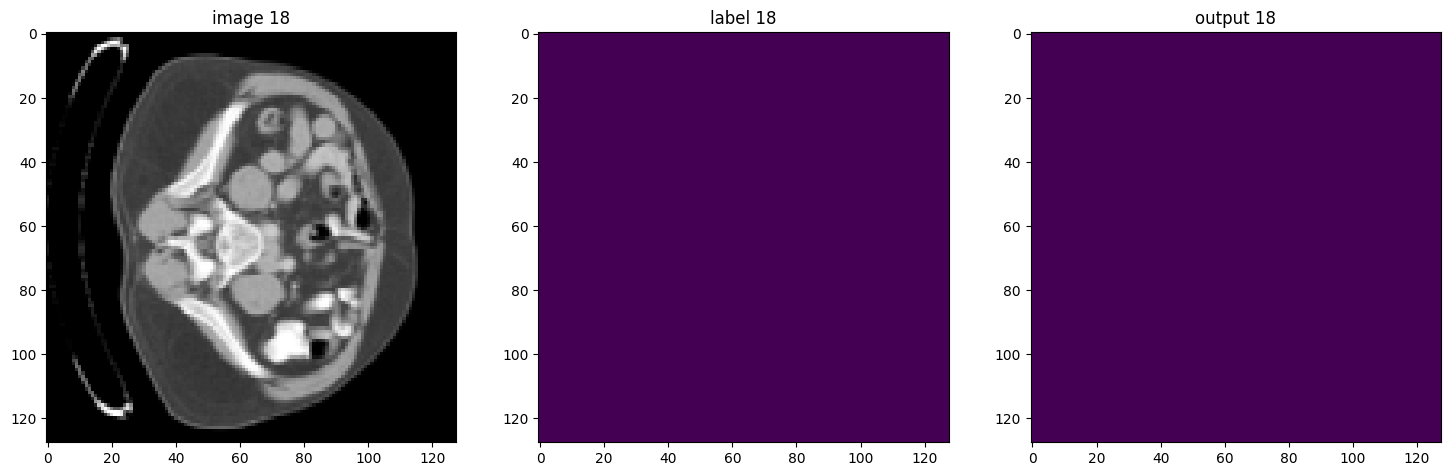

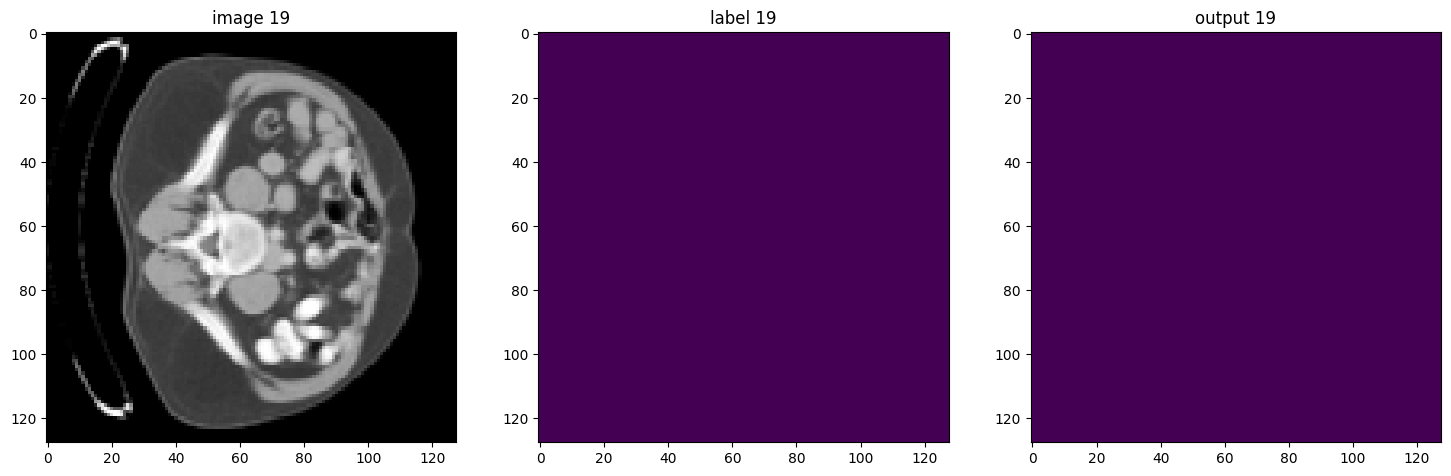

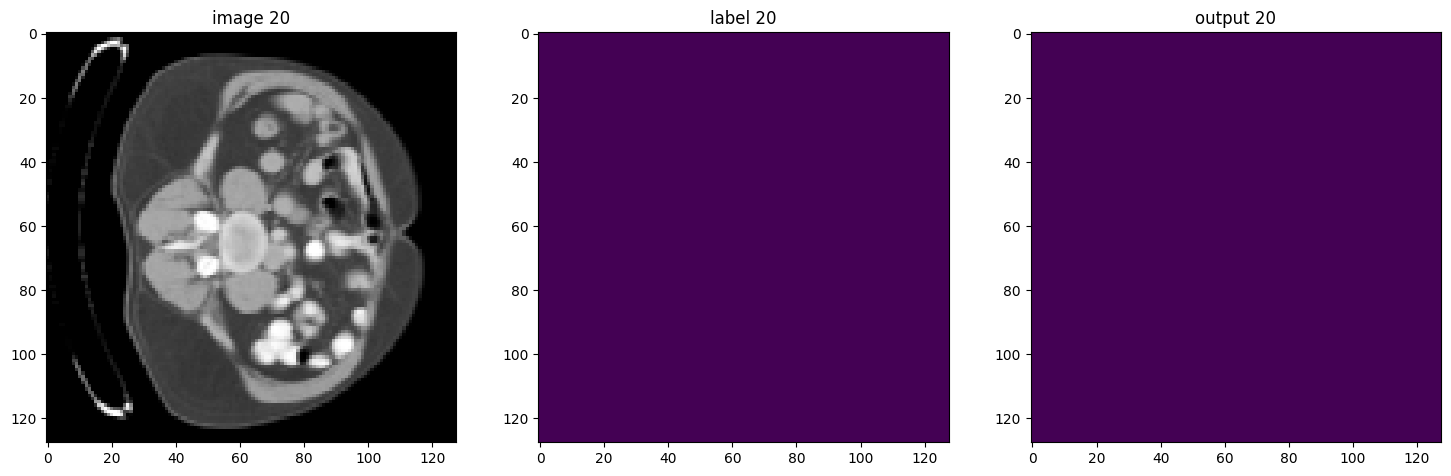

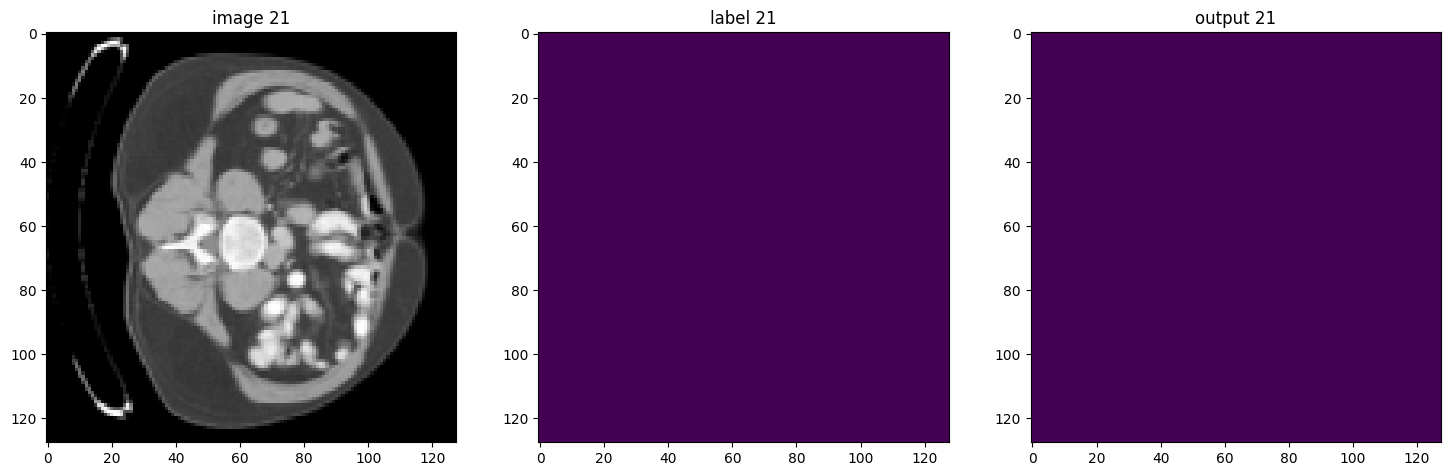

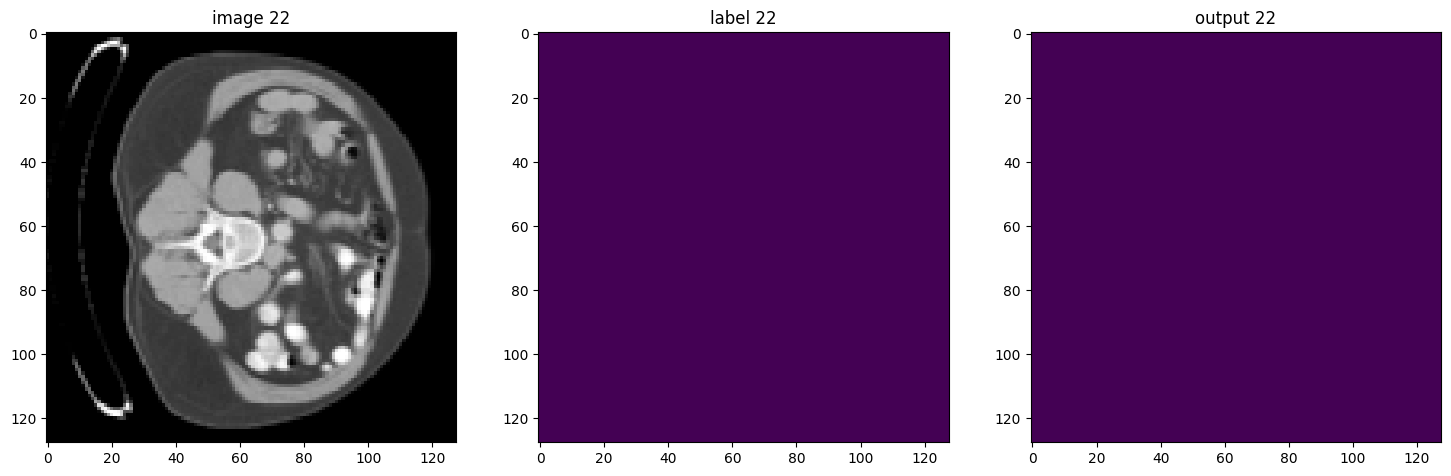

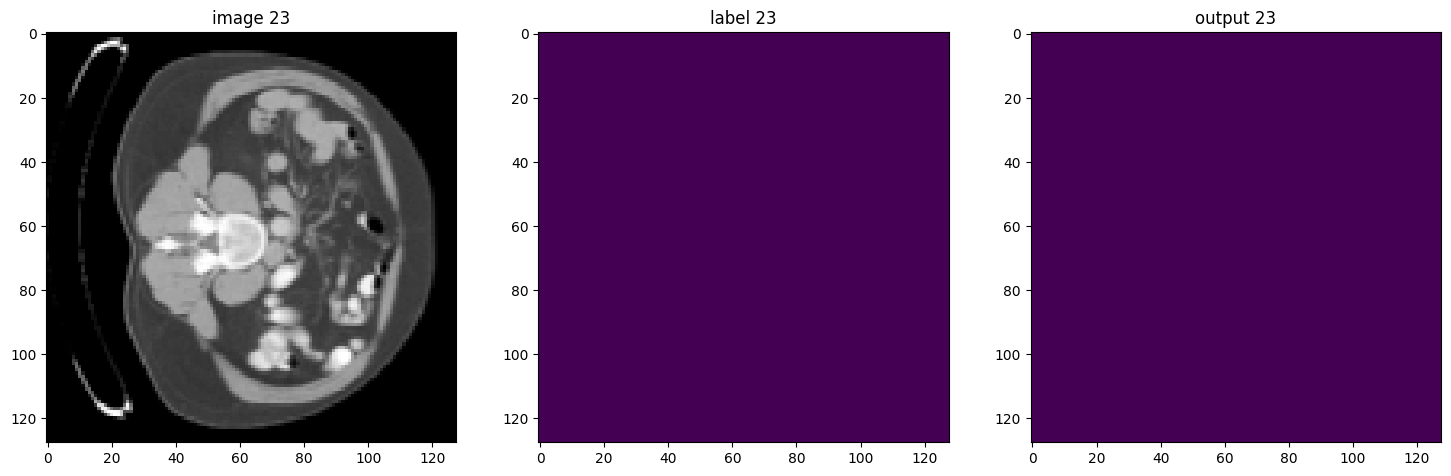

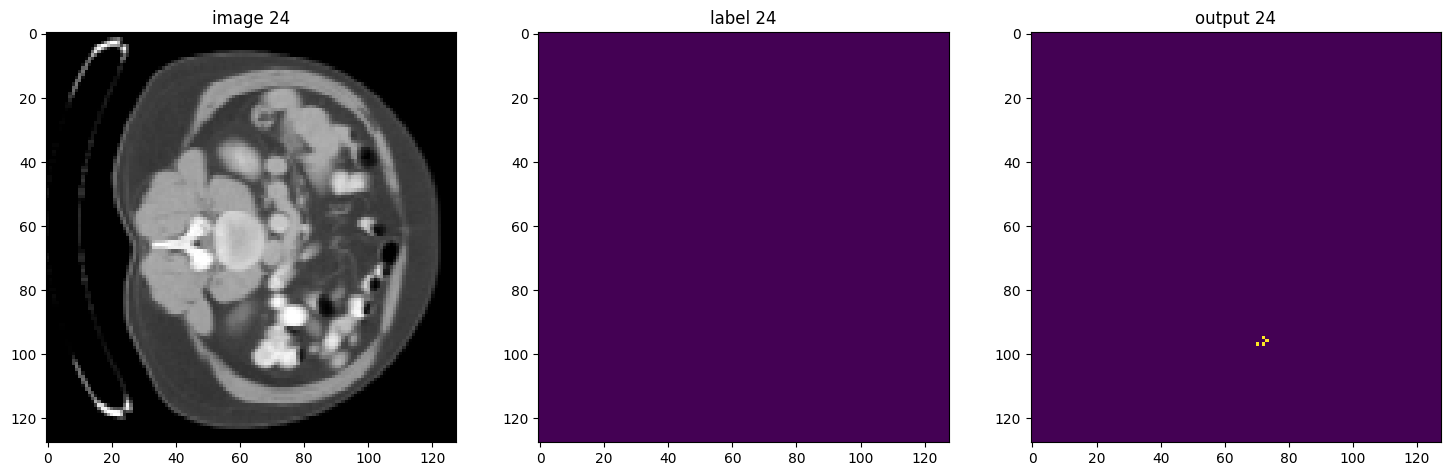

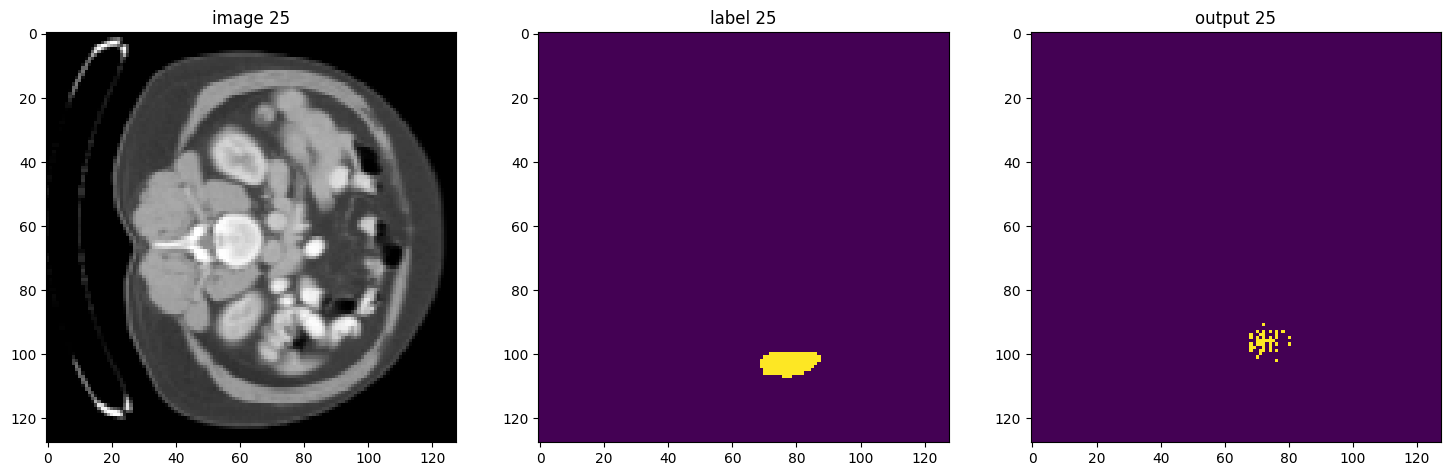

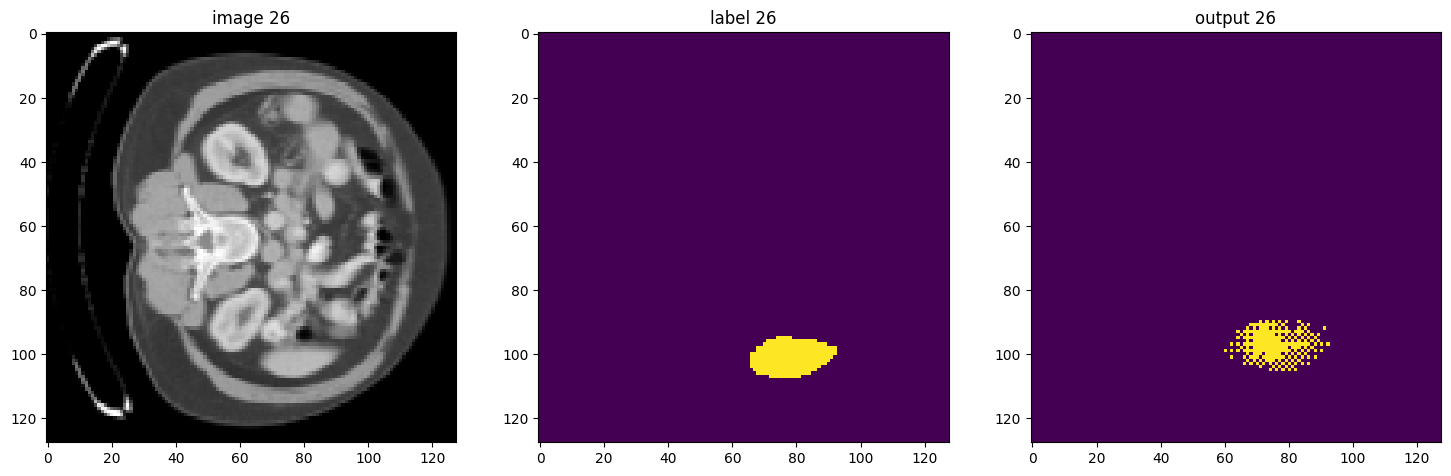

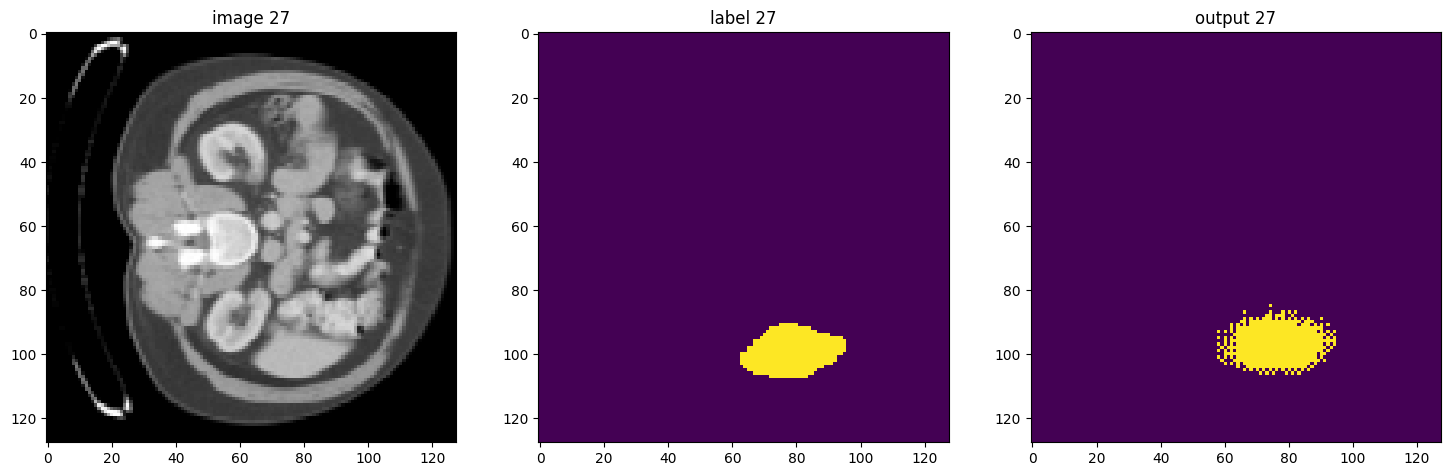

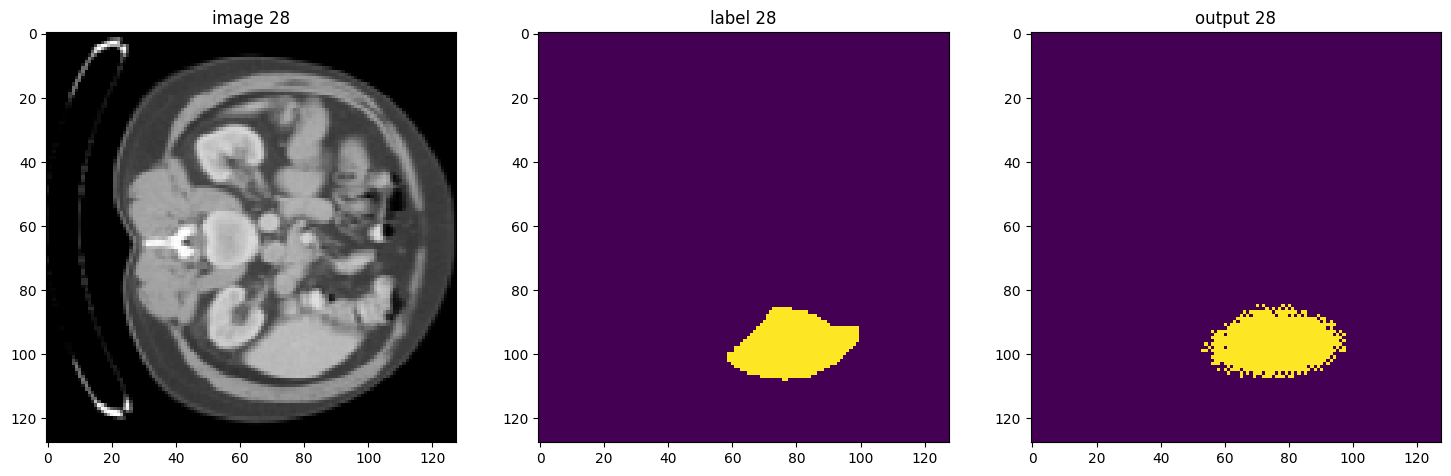

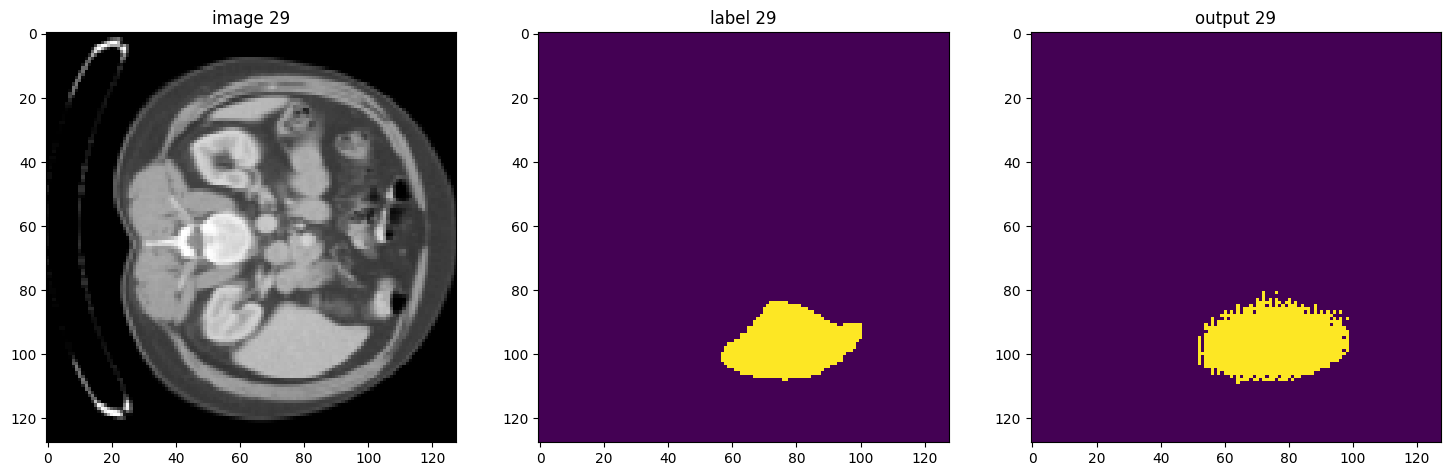

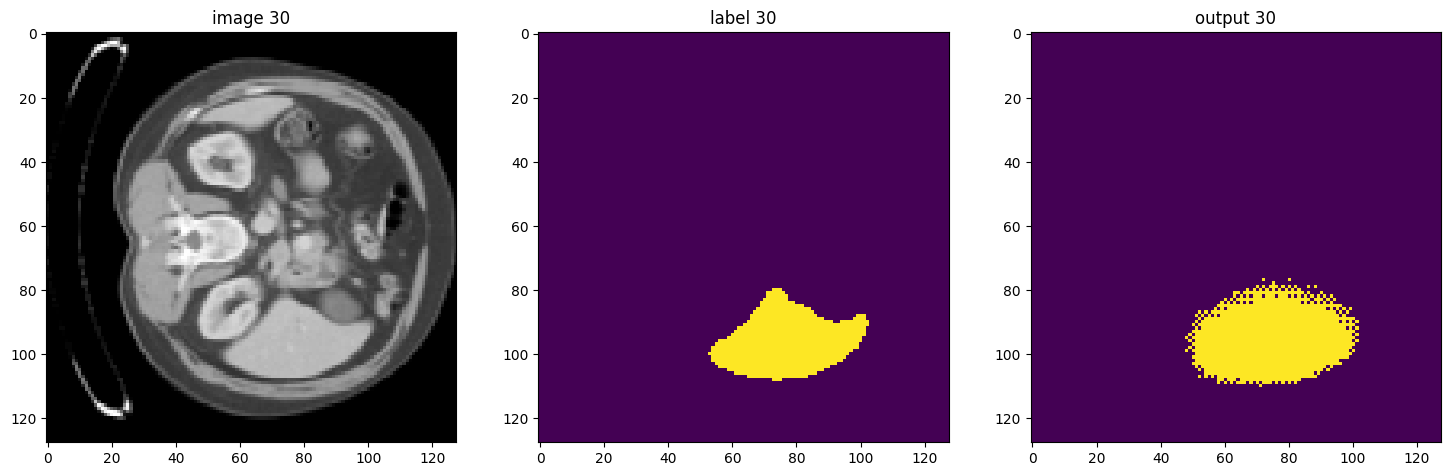

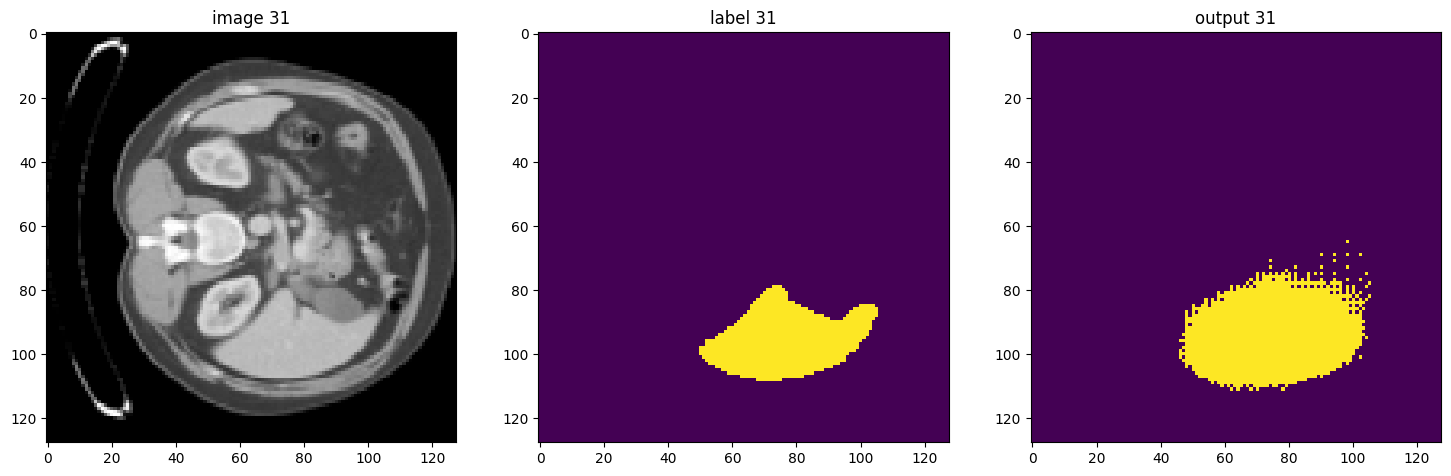

In [49]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.70
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

For checking with random Images

In [38]:
def select_patient(image_num):

    # Create dataset
    test_ds = Dataset(data=test_files, transform=test_transforms)

    # Access the second image
    second_image = test_ds[image_num-1]

    # If you want to create a DataLoader for this single image
    test_loader = DataLoader([second_image], batch_size=1)

    # Retrieve the image using the DataLoader
    test_patient = first(test_loader)

    return test_patient

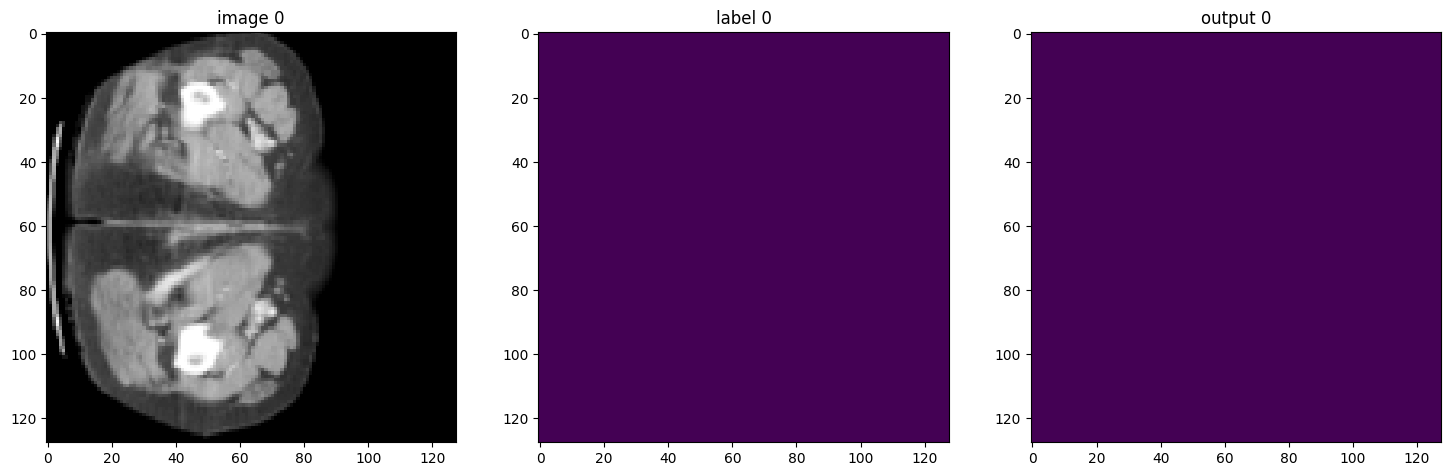

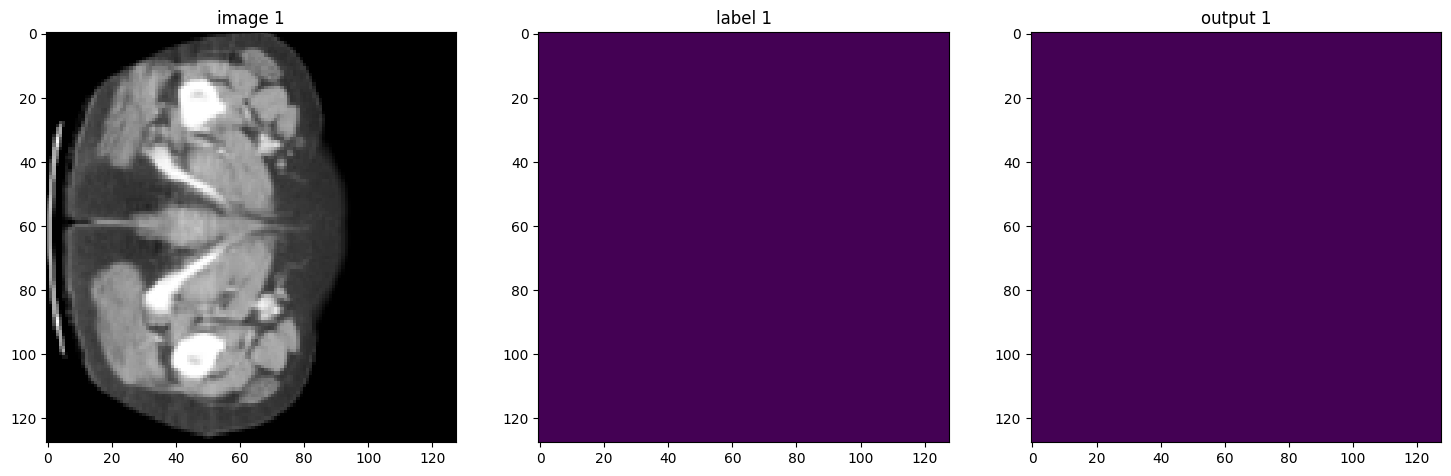

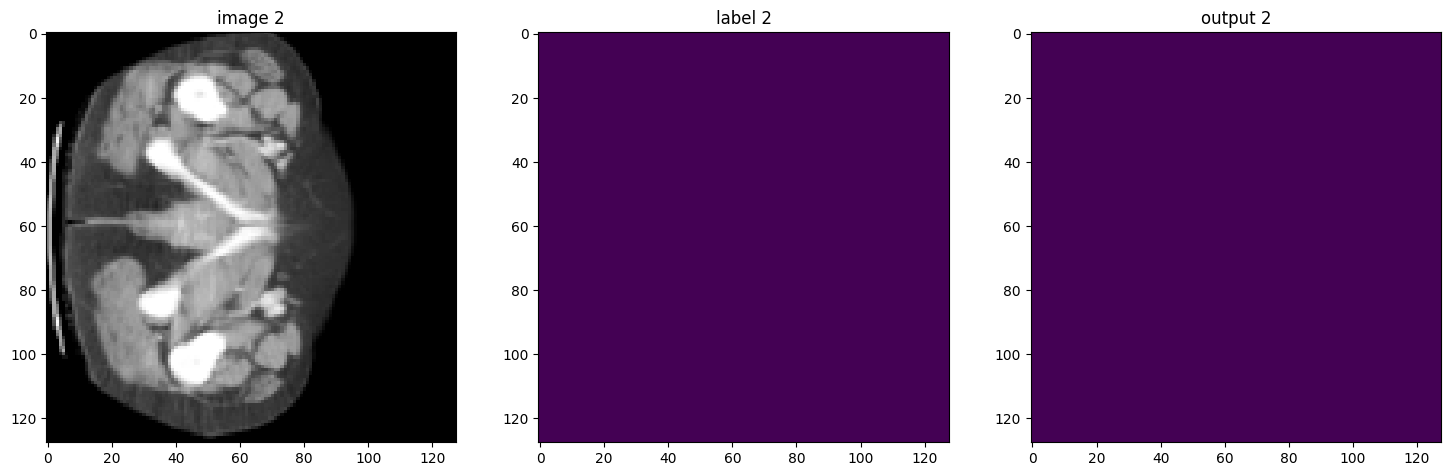

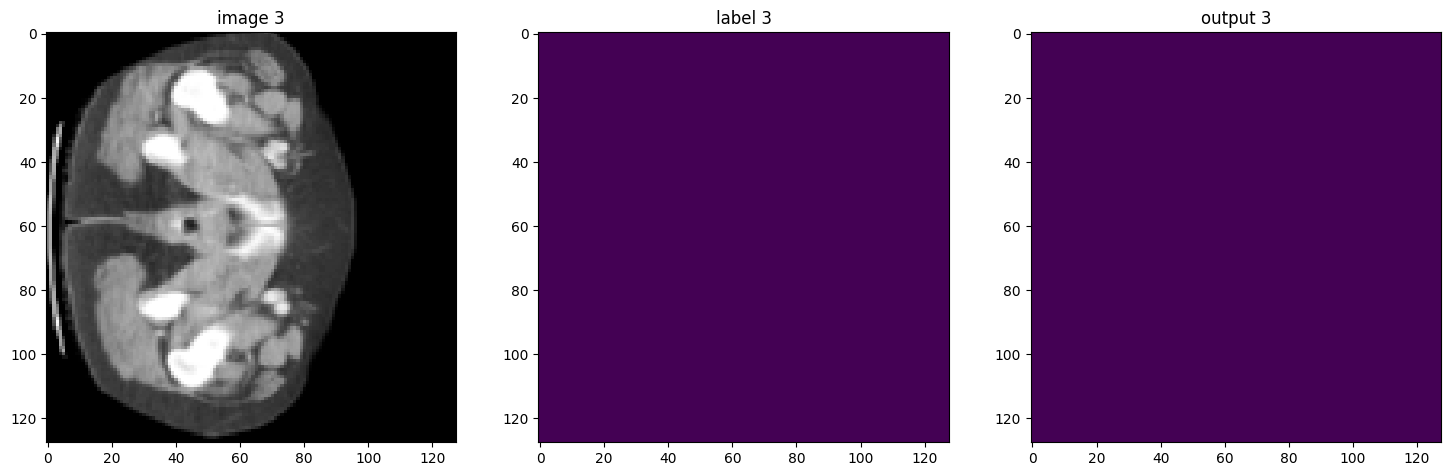

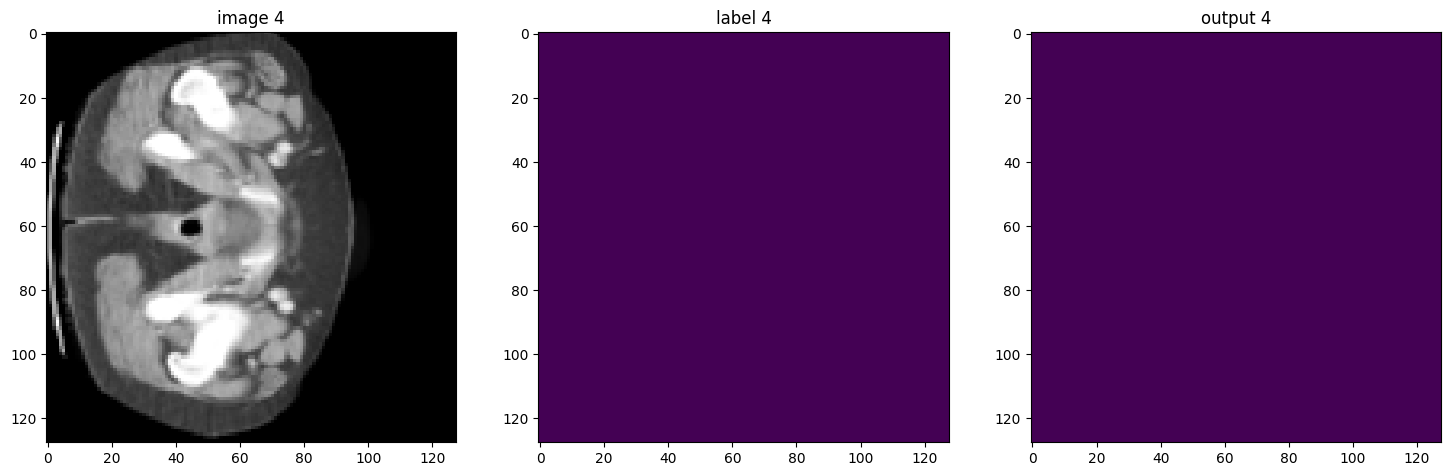

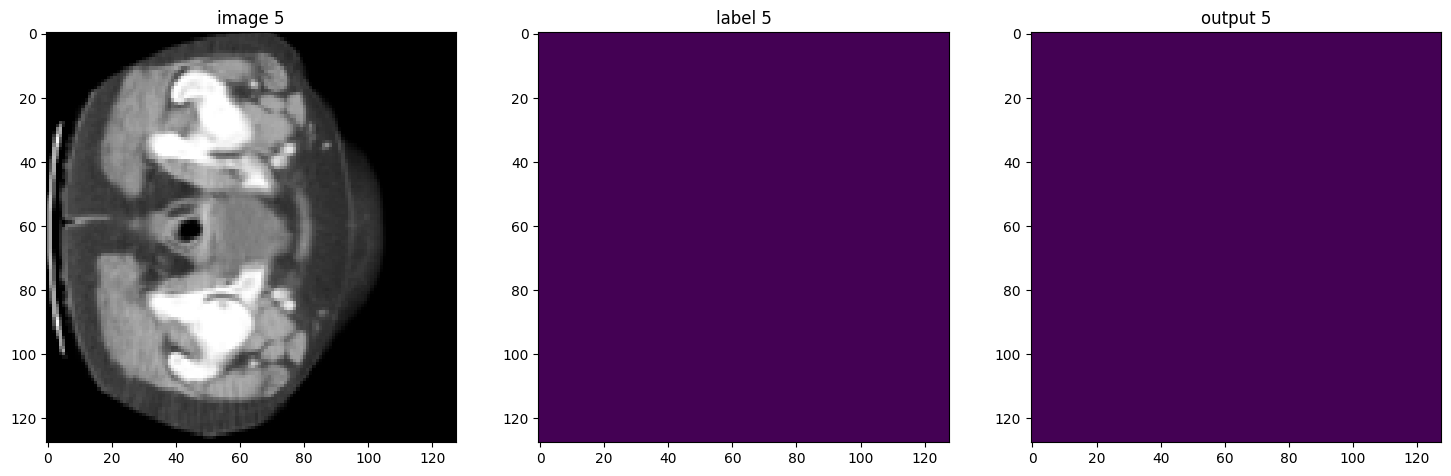

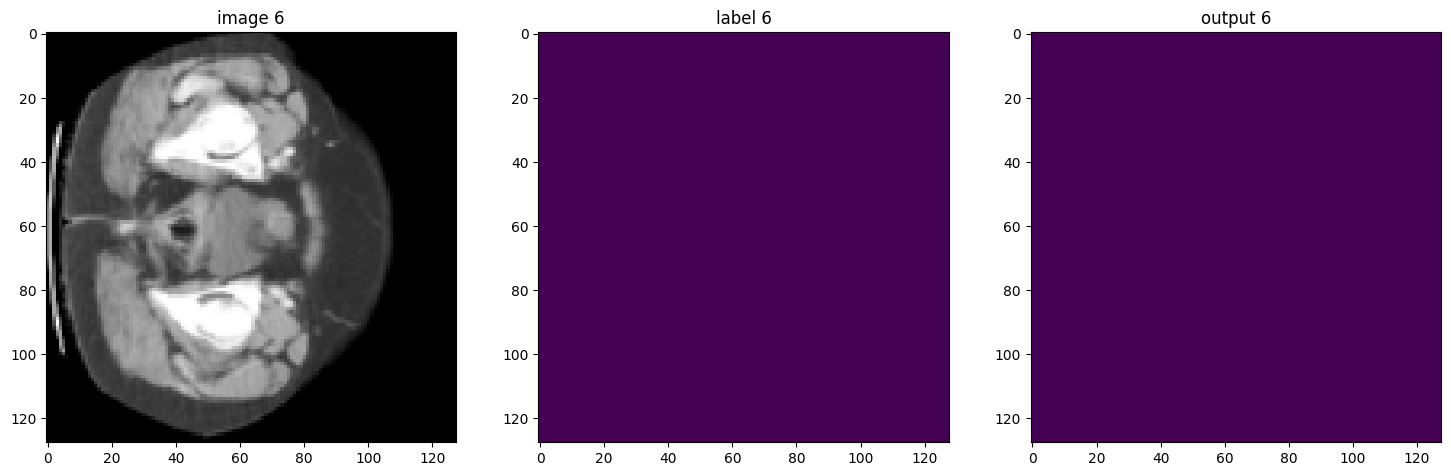

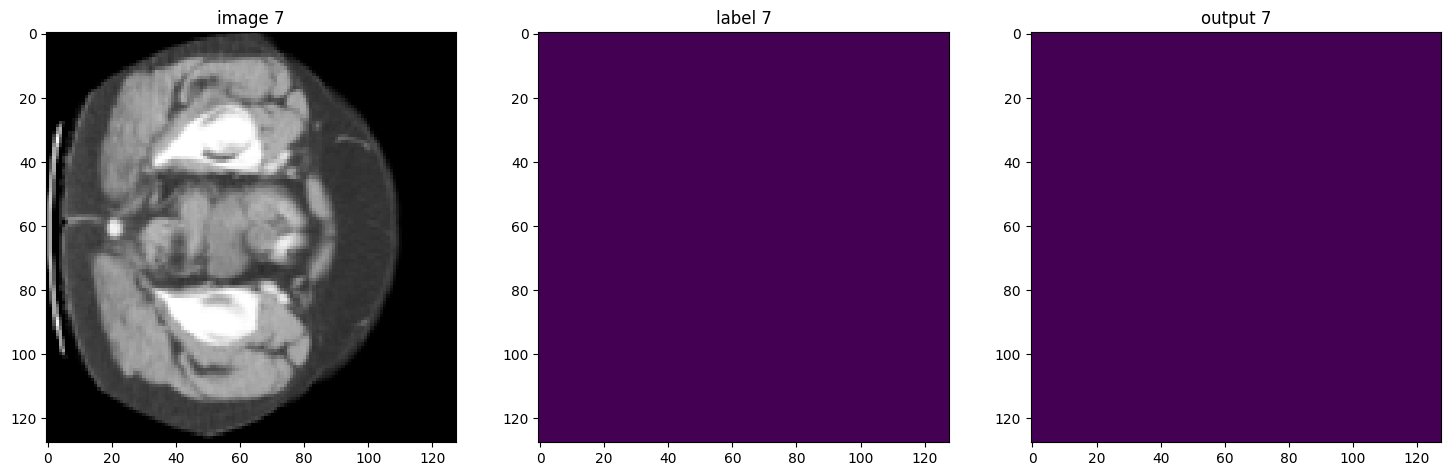

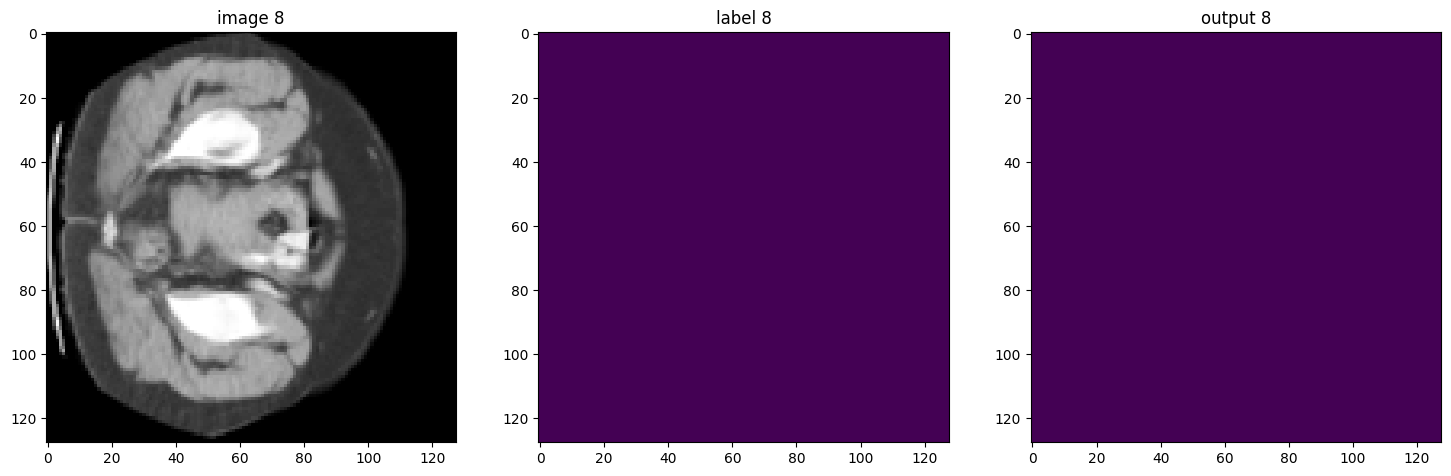

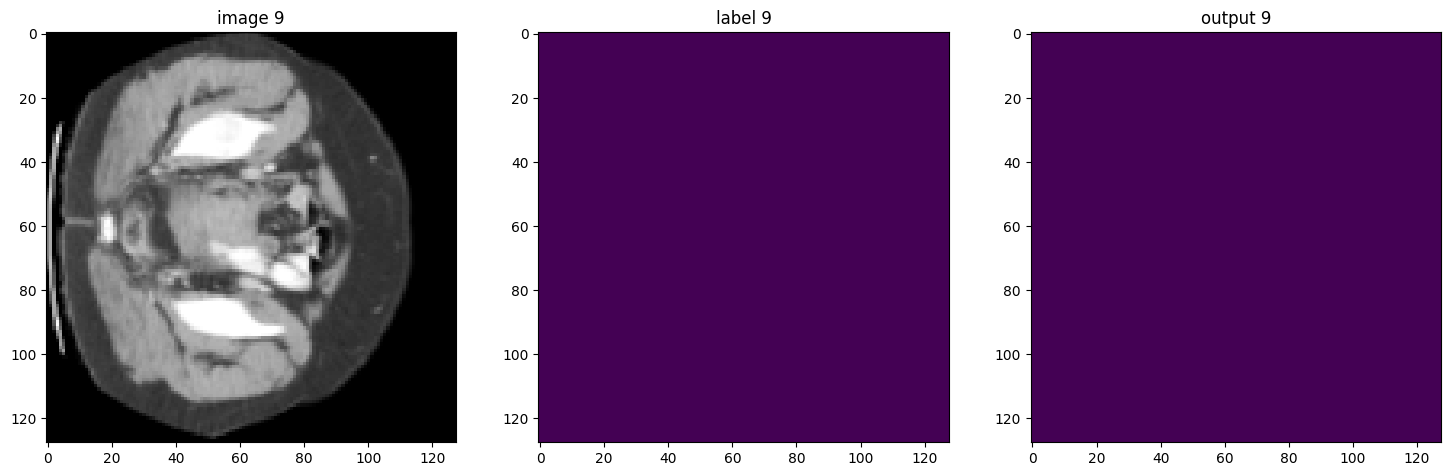

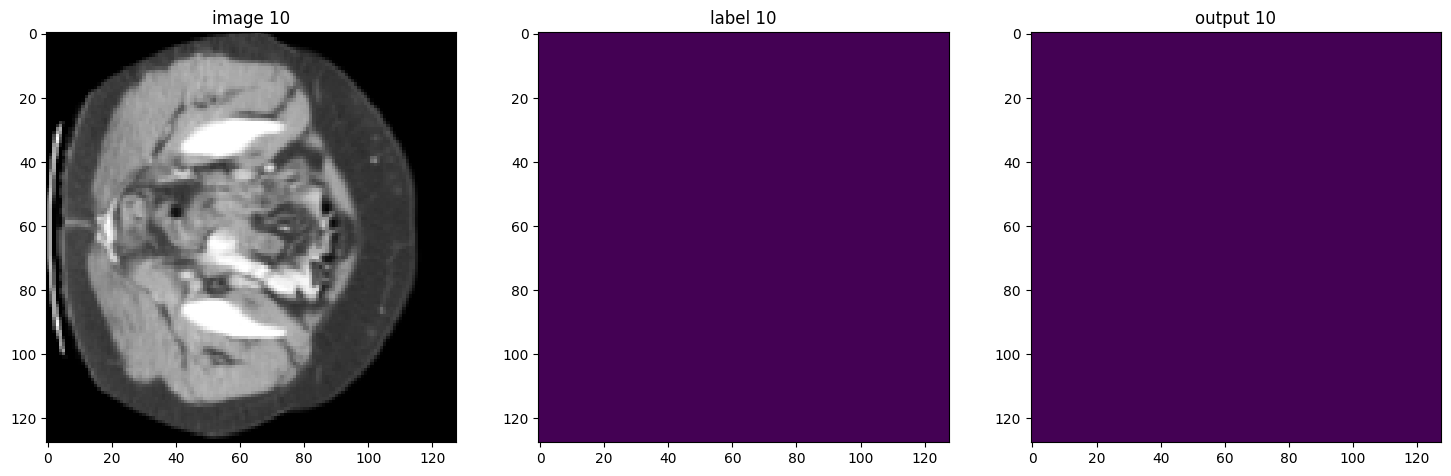

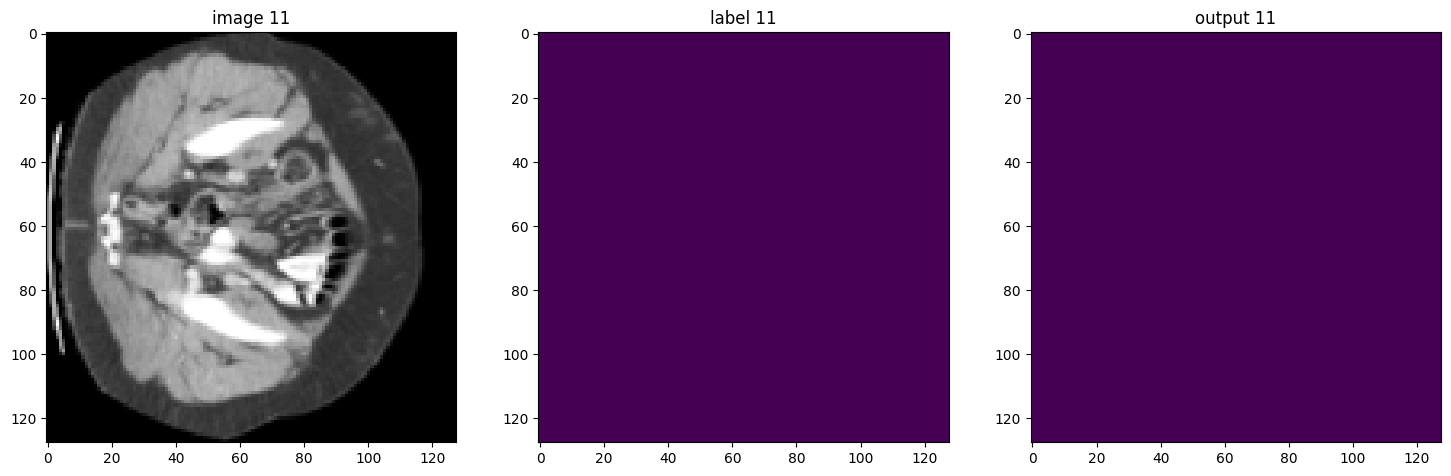

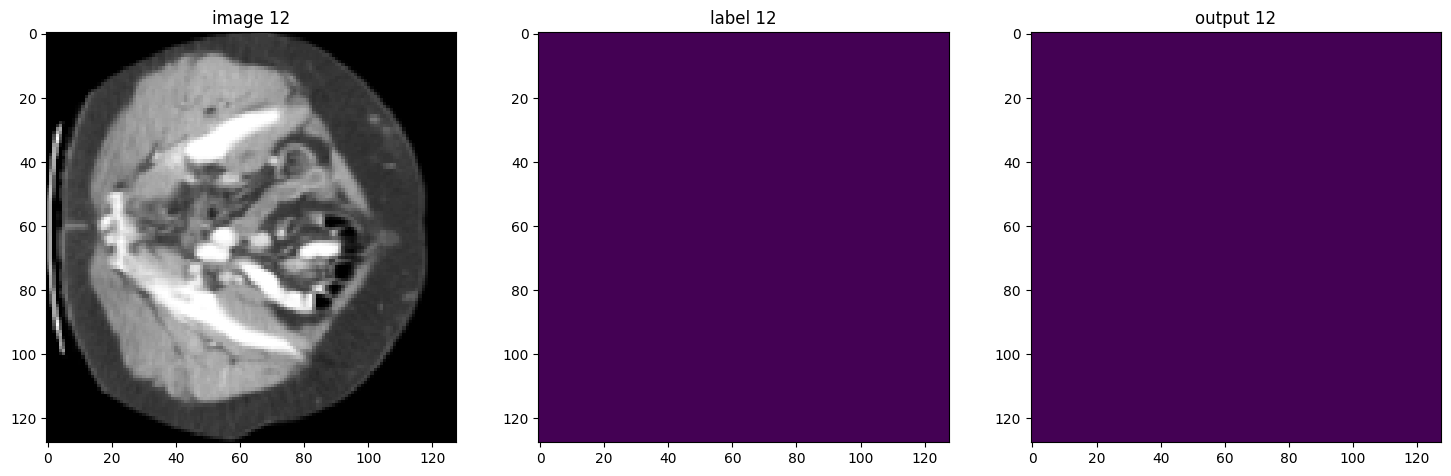

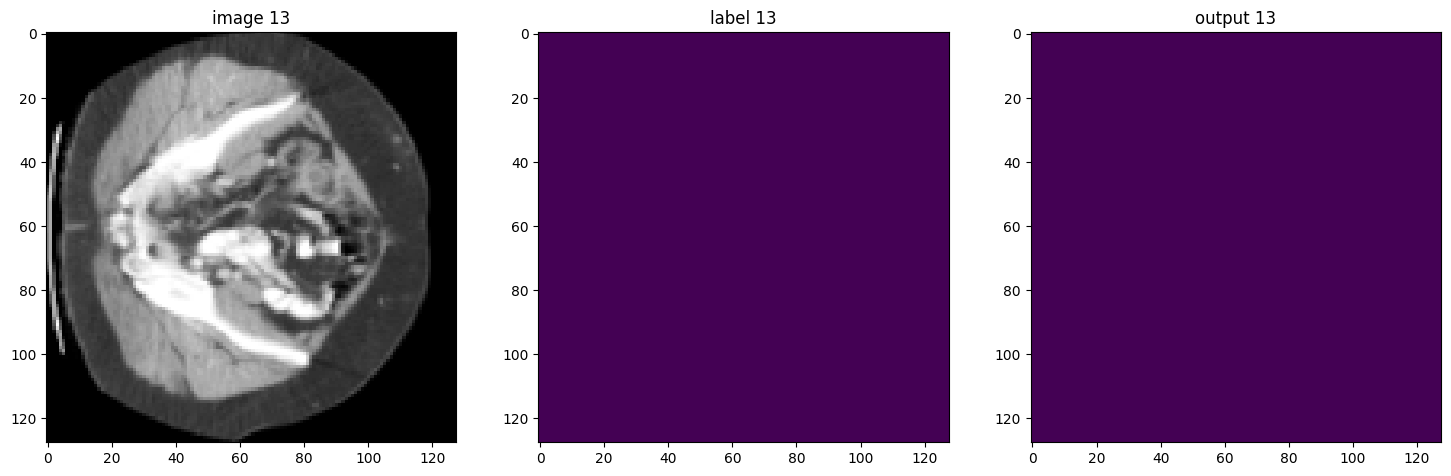

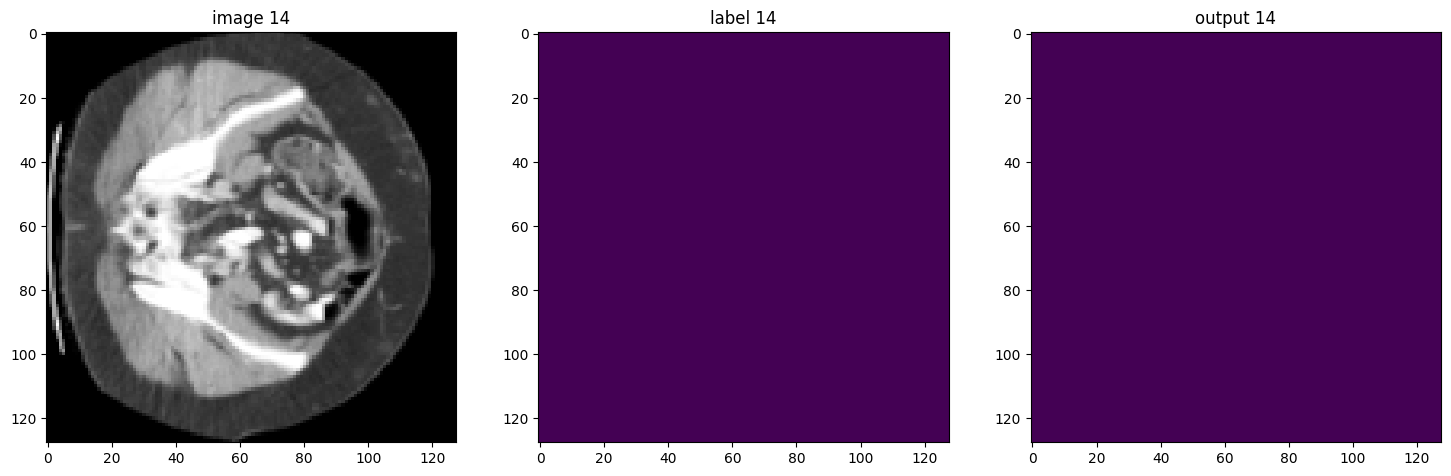

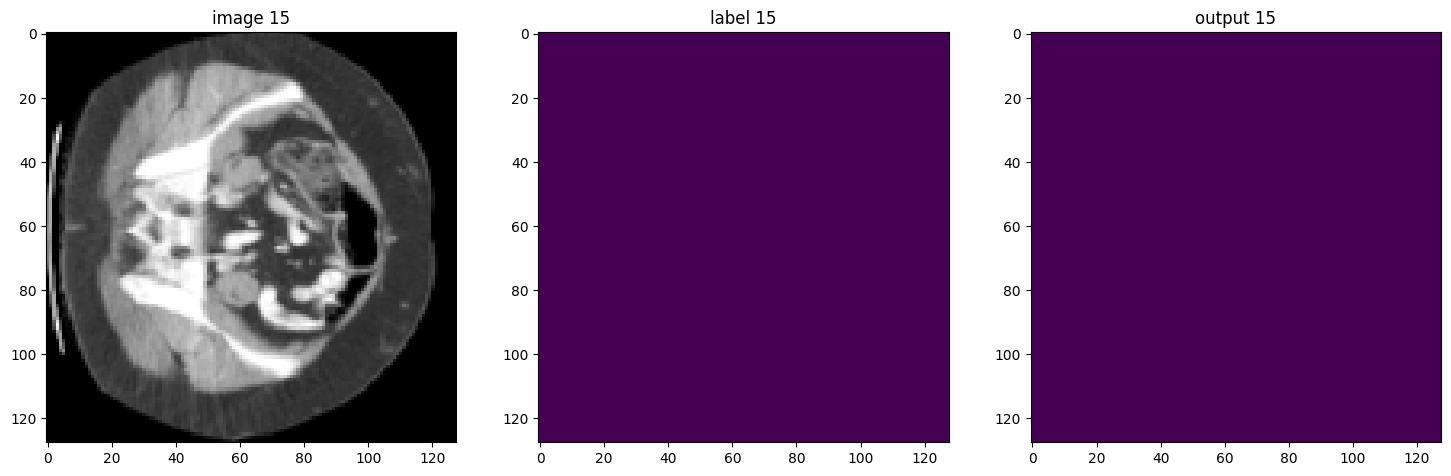

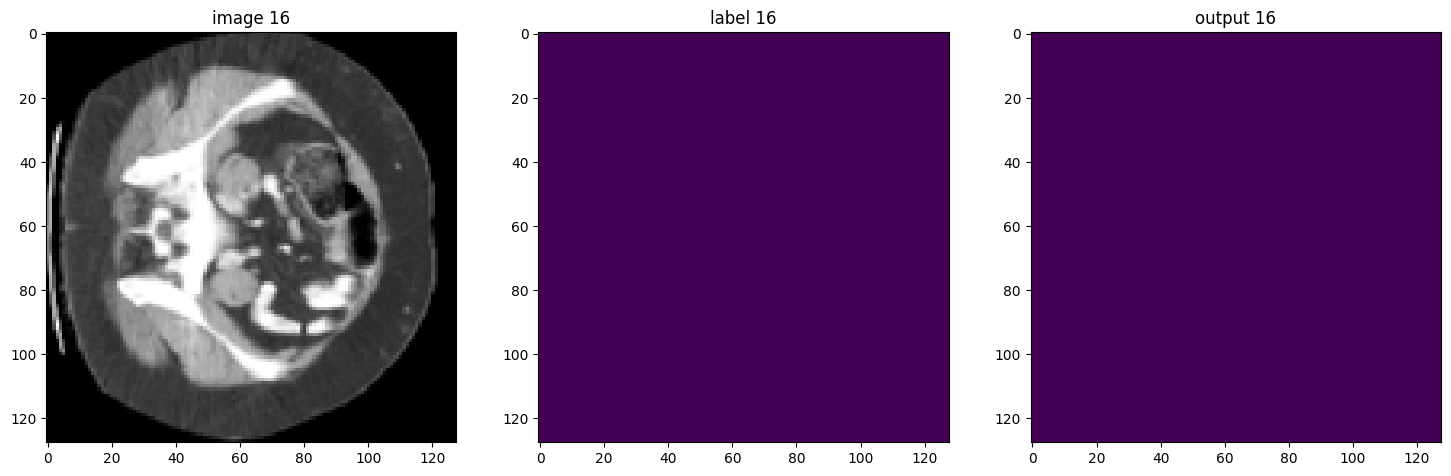

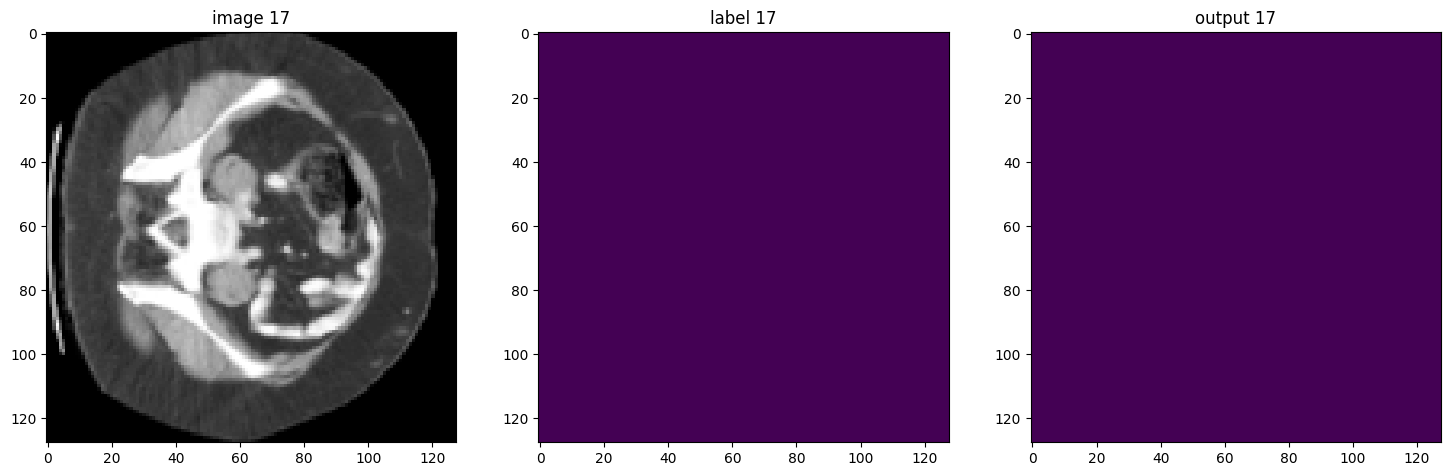

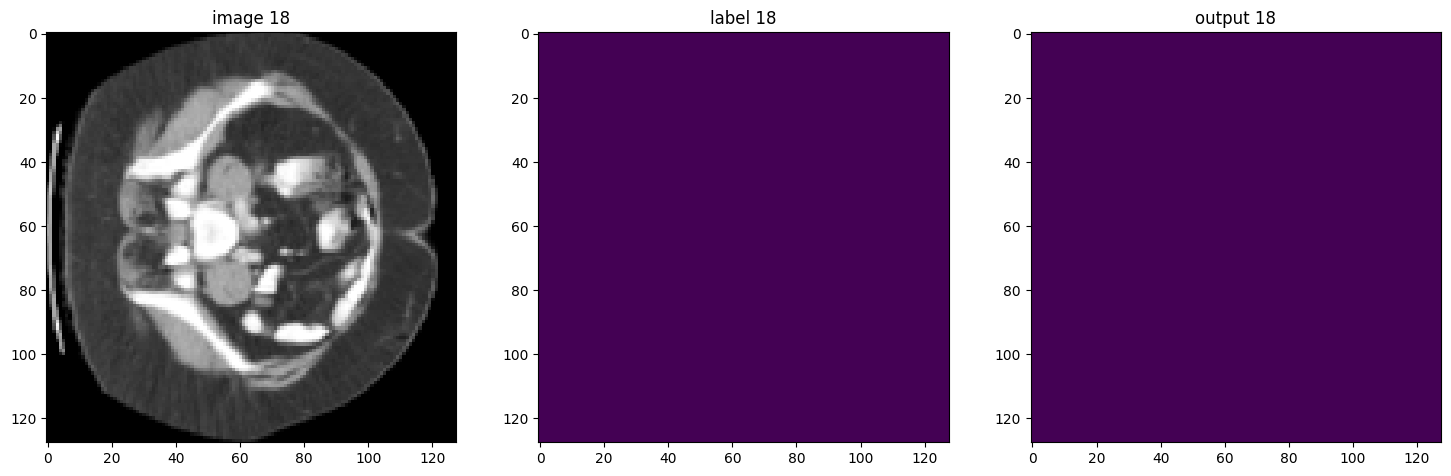

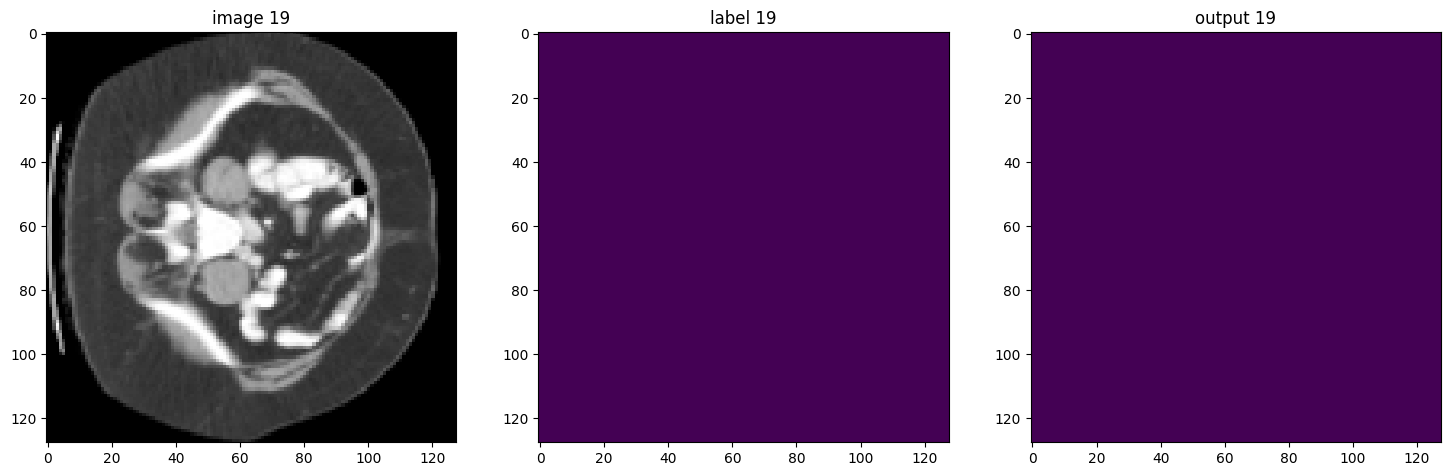

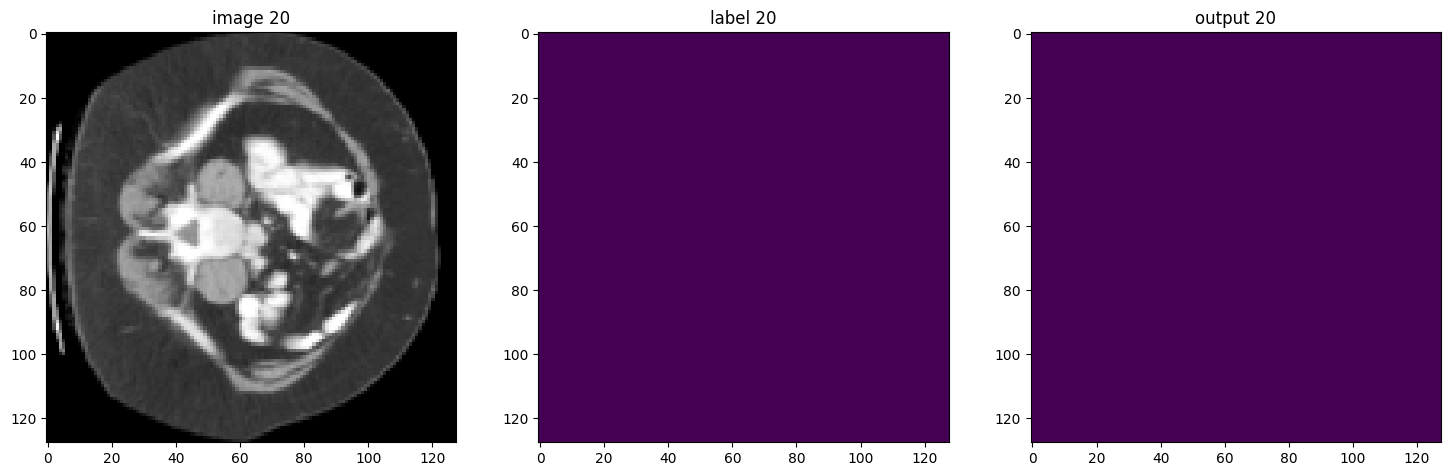

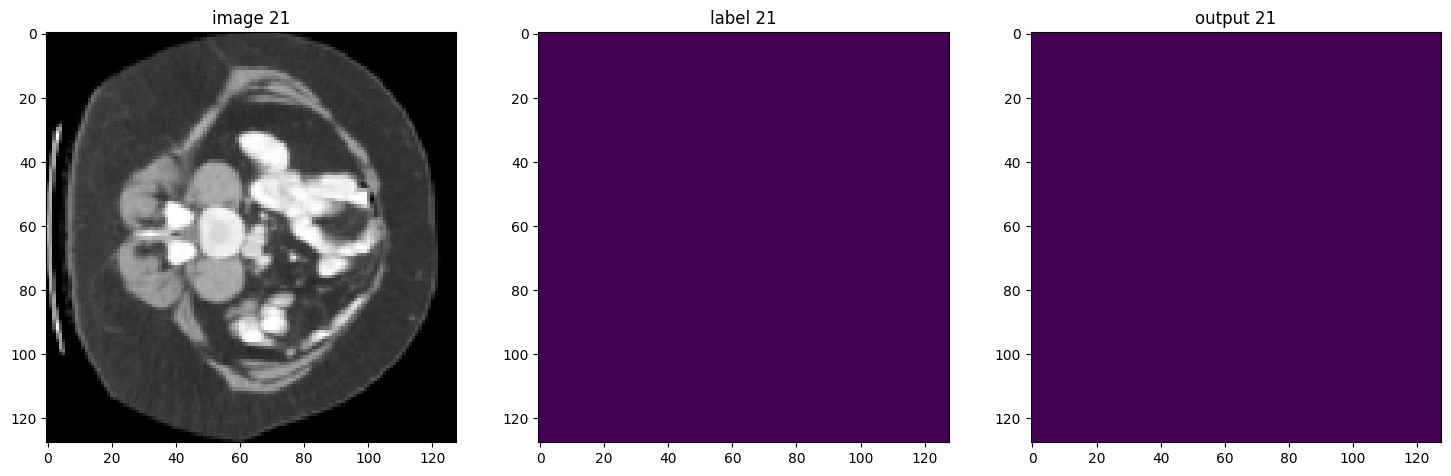

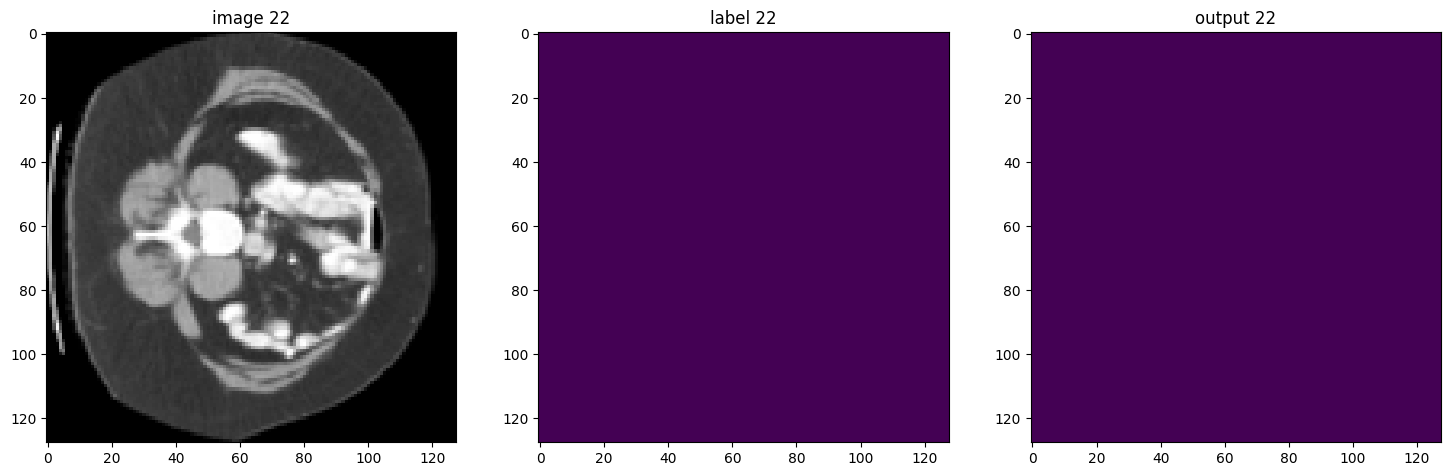

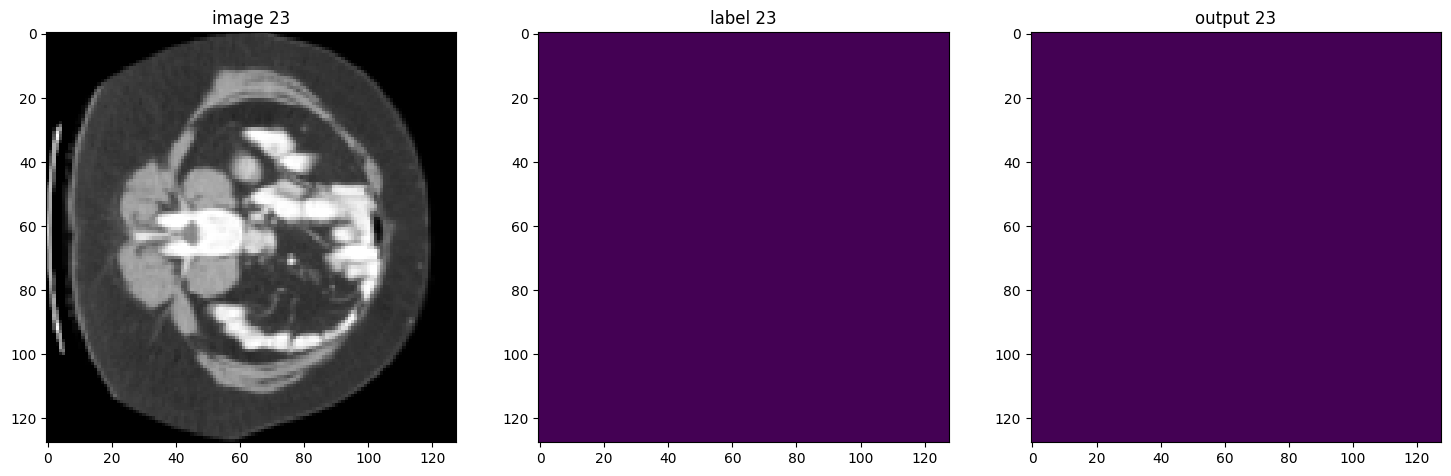

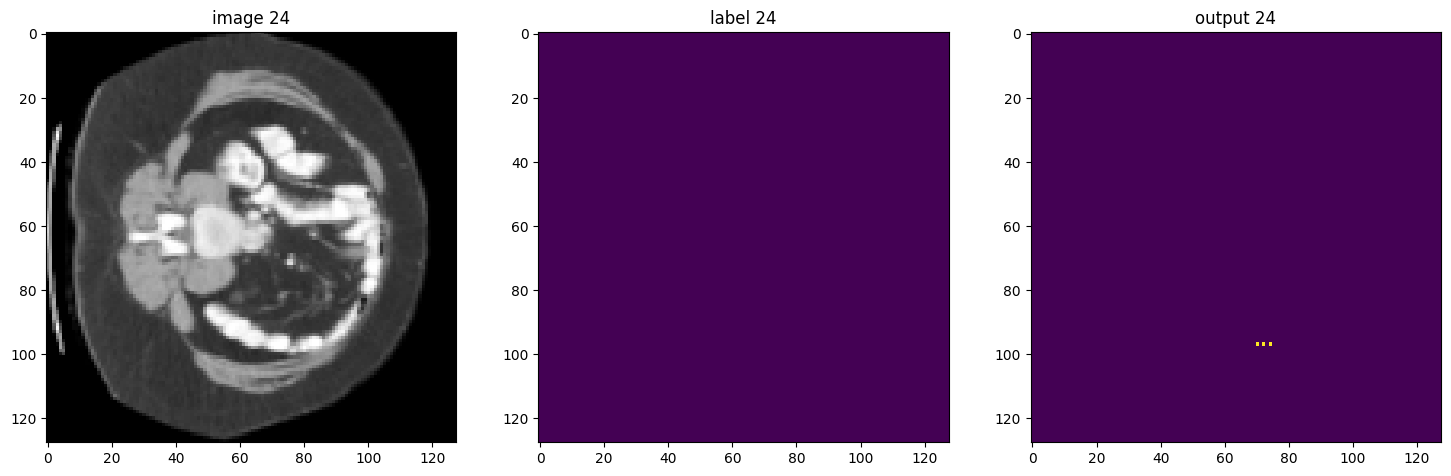

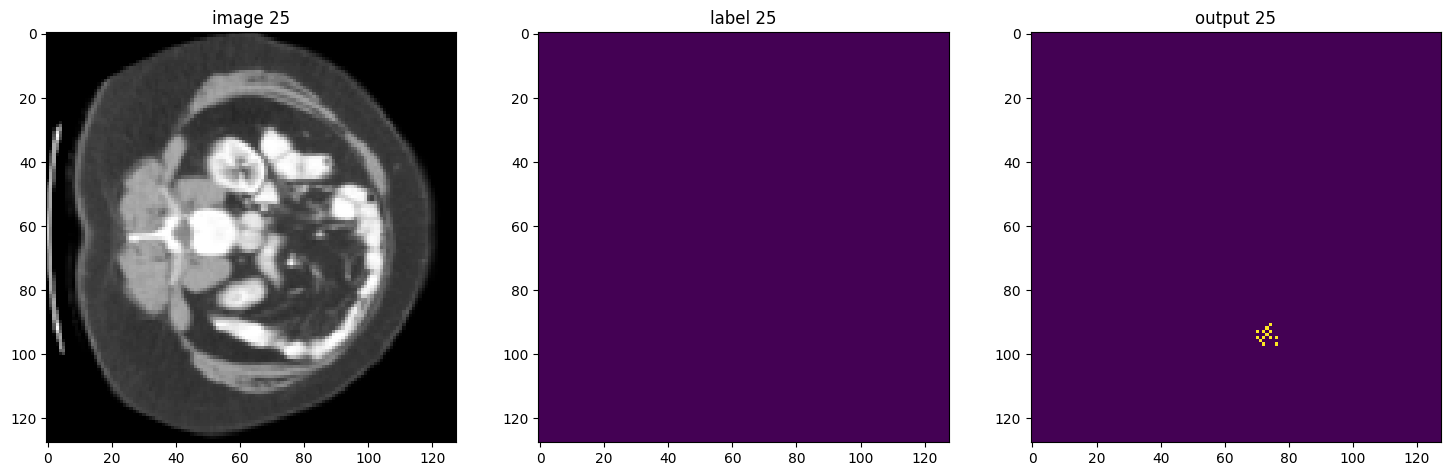

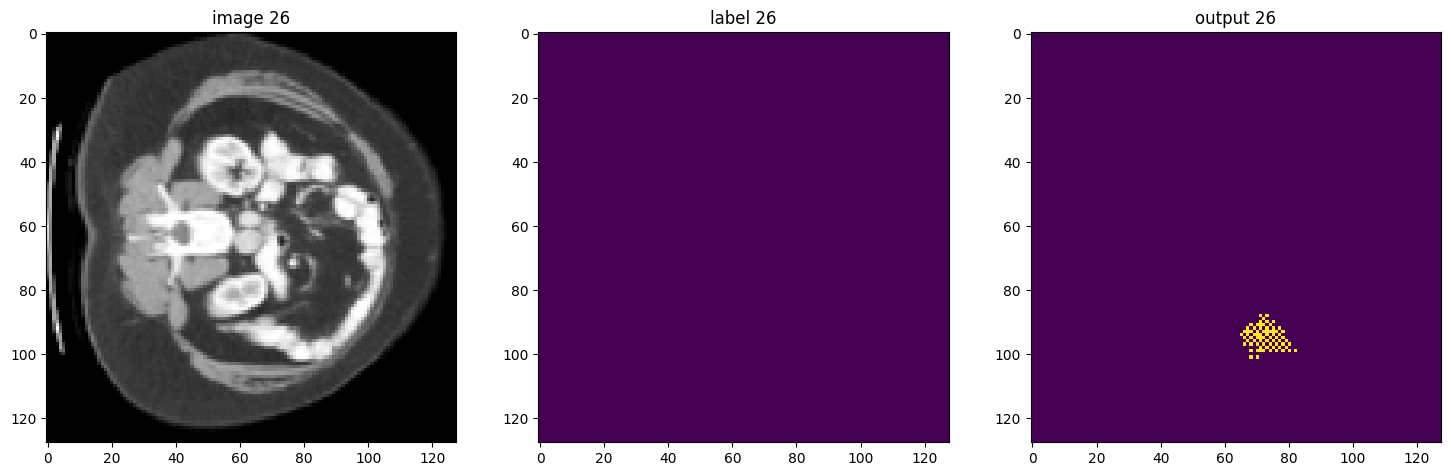

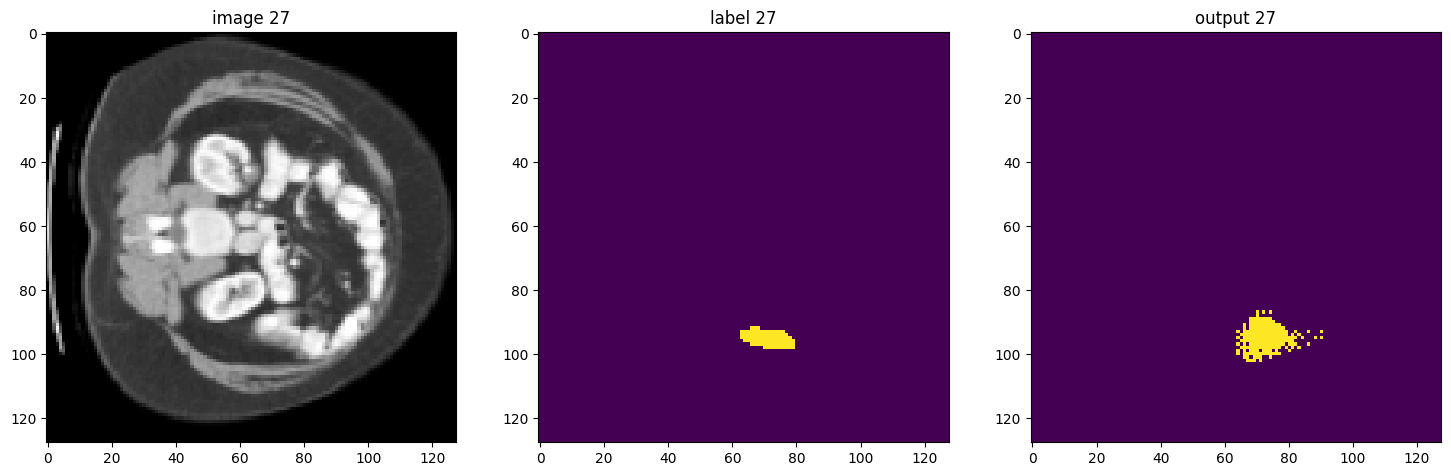

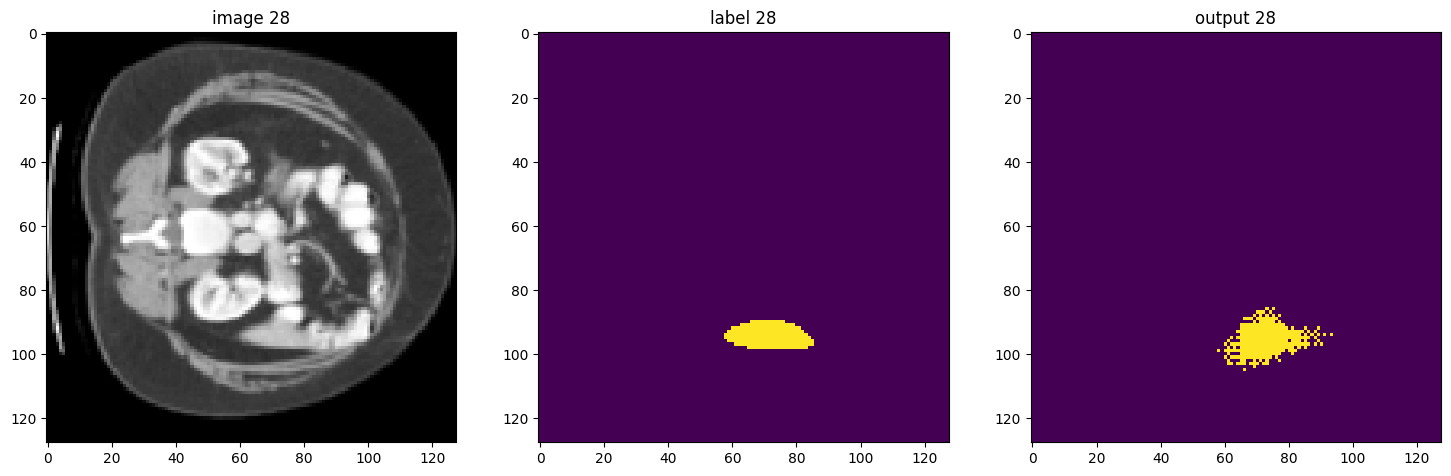

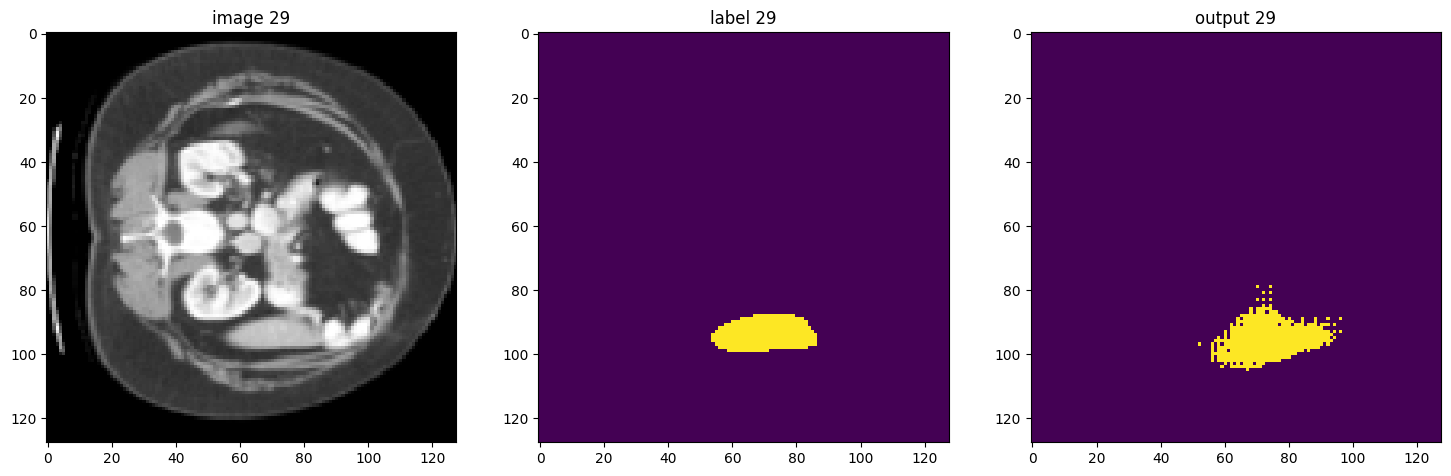

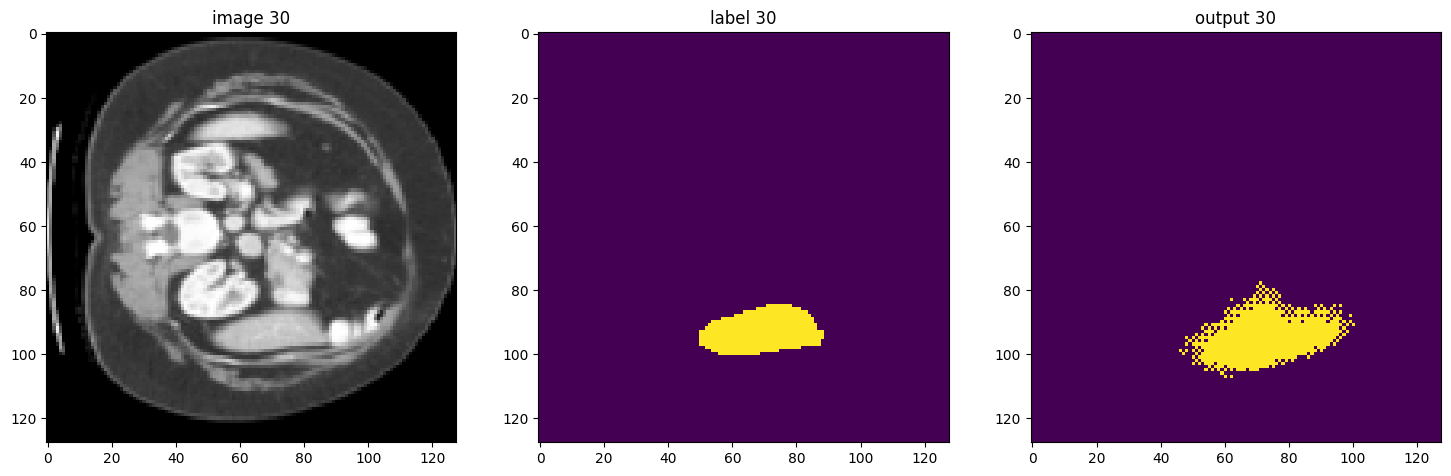

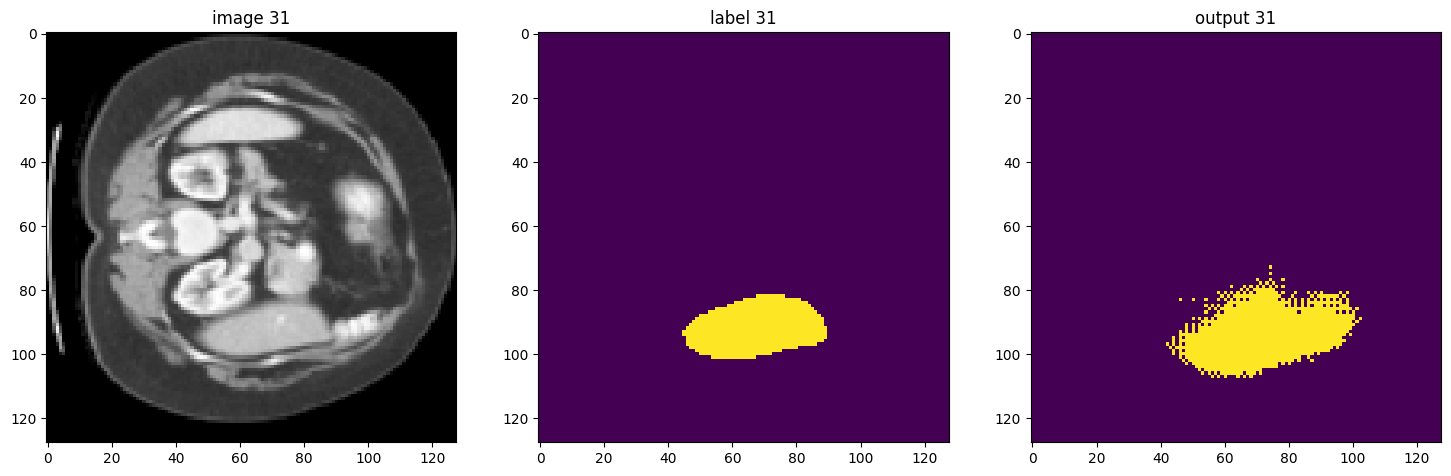

In [54]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = select_patient(10)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.70
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()